# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


### Libraries

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/CV/Project/Code')
from models import GbcNet

import random
import json
import torch
import pickle
import os
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

import copy
import time
import math
import cv2
from PIL import Image
import torch.nn.functional as F
from torchvision.transforms import Resize, ToTensor, Compose, GaussianBlur
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torch.nn.init as init
from torch.optim import SGD, Adam, NAdam
#from torchmetrics.detection import MeanAveragePrecision
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import one_hot

from sklearn.metrics import roc_auc_score

from torchvision.utils import draw_bounding_boxes
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### File Paths

In [ ]:
!unzip "/content/drive/MyDrive/CV/Project/data/images.zip" -d "/content"
imgs_folder_path = "/content/images"
gold_file_path = "/content/drive/MyDrive/CV/Project/data/gold_boxes.json"
gbcnet_weight_path = "/content/drive/MyDrive/CV/Project/Code/Original Models/init_weights.pth"

### Helper Functions

In [ ]:
def read_txt(txt_path):
  ids = []
  cls = []
  with open(txt_path,"r") as f:
    for line in f.readlines():
      ids.append(line.strip().split(',')[0])
      cls.append(int(line.strip().split(',')[1]))

  return ids, cls

def read_json(json_path):
  with open(json_path, "r") as f:
    json_file = json.load(f)

  return json_file

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize(img, pred_bboxes=None, title=None):
    print("visualize")
    edgecolors = ["y", "r", "c"]
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot the original image with bounding box
    if torch.is_tensor(img):
      ax.imshow(img.permute(1, 2, 0).numpy())
    else:
      ax.imshow(img)
    if pred_bboxes is not None:
      for i in range(len(pred_bboxes)):
        pred_bbox = pred_bboxes[i]
        rect = patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2]-pred_bbox[0], pred_bbox[3]-pred_bbox[1], linewidth=2, edgecolor=edgecolors[i], facecolor='none')
        ax.add_patch(rect)
    ax.set_title(title)

    plt.show()


def gold_box_proportion(x):
  if x < 30:
    return 1
  elif 30 <= x < 35:
    return 0.75
  elif 35 <= x < 40:
    return 0.5
  elif 40 <= x < 45:
    return 0.25
  else:
    return 0

def print_status(txt, status_flag):
  if status_flag==False:
    print(txt)
  return True

def filter_background(predictions):
  # Filter out the predictions with label 0
  filtered_predictions = []
  for prediction in predictions:
      mask = prediction['labels'] != 0
      filtered_prediction = {k: v[mask] for k, v in prediction.items()}
      filtered_predictions.append(filtered_prediction)
  return filtered_predictions

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

### Transforms

In [ ]:
class img_bbox_transform(object):
    def __init__(self, target_width, target_height):
      self.target_width = target_width
      self.target_height = target_height
      self.transforms = Compose([Resize((self.target_width, self.target_height)),
                                ToTensor()])

    def __call__(self, image=None, bbox = None, current_width=None, current_height=None):
      transformed_image = None
      if image is not None:
        current_width, current_height = image.size
        transformed_image = self.transforms(image)
      transformed_bbox = None
      if bbox is not None:
        transformed_bbox = self.transform_bbox(bbox, current_width, current_height)
      return transformed_image, transformed_bbox

    def transform_bbox(self, bbox, current_width=None, current_height=None):
      new_x1 = bbox[0]*self.target_width/current_width
      new_y1 = bbox[1]*self.target_height/current_height
      new_x2 = bbox[2]*self.target_width/current_width
      new_y2 = bbox[3]*self.target_height/current_height
      return [round(new_x1.item()), round(new_y1.item()), round(new_x2.item()), round(new_y2.item())]


def crop_image(image, box, p):
    x1, y1, x2, y2 = box
    # Input images in CHW
    cropped_image = image[:, int((1-p)*y1):int((1+p)*y2), int((1-p)*x1):int((1+p)*x2)]
    return cropped_image

def get_train_transforms(width, height, p=None):
    return A.Compose([
        A.Rotate(limit=5, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.6, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit= 0.1, p=0.5),
        A.HueSaturationValue(hue_shift_limit=3, sat_shift_limit=5, val_shift_limit=0, p=0.5),
        A.MotionBlur(blur_limit=(3, 5), p=0.5),
        A.Perspective(scale=(0.01, 0.05), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1, always_apply=False, p=0.7),
        A.MultiplicativeNoise(multiplier=(0.9, 1.1), p=0.5),
        A.Resize(height=height, width=width, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_eval_transforms(width, height):
    return A.Compose([
        A.Resize(height=height, width=width, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

### Dataset

In [ ]:
class InputDataset(Dataset):
    def __init__(self, img_folder, id_txt, gold_json, p=0.15, width=224, height=224, img_transforms=None, do_crop=None, predicted_bboxes_json=None, to_blur=False, blur_kernel_size=(65,65), sigma=0):
        self.img_folder = img_folder
        self.id_txt = id_txt
        self.gold_json = gold_json
        self.to_blur = to_blur
        self.blur_kernel_size = blur_kernel_size
        self.sigma = sigma
        self.do_crop=do_crop
        self.p=p
        self.width=width
        self.height=height
        self.transforms = img_transforms
        self.ids, self.true_labels = read_txt(id_txt)
        self.gold_dict = read_json(gold_json)
        self.predicted_boxes = None
        if predicted_bboxes_json is not None:
          self.predicted_boxes=read_json(predicted_bboxes_json)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_label = self.true_labels[idx]
        gold_bbox = self.gold_dict[img_id]['Gold']
        img_path = f"{self.img_folder}/{img_id}"
        img = cv2.imread(img_path)
        img_height, img_width, _ = img.shape
        if self.to_blur:
          img = cv2.GaussianBlur(img, self.blur_kernel_size, self.sigma)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if (self.do_crop==None) or (self.do_crop=="gold_boxes"):
          transformed_dict = self.transforms(image=img, bboxes=[gold_bbox], labels=[1])
        elif self.do_crop=="pred_boxes":
          pred_bbox = self.predicted_boxes[img_id]['Boxes']
          transformed_dict = self.transforms(image=img, bboxes=[pred_bbox], labels=[1])

        #visualize(img, pred_bboxes=[gold_bbox, pred_bbox], title=f"raw image {img_id}")
        transformed_img = transformed_dict['image'].float().div(255)
        transformed_bboxes = [round(x) for x in transformed_dict['bboxes'][0]]
        #visualize(transformed_img, [[0,0,0,0], transformed_bboxes], title=f"transformed img {img_id}")

        if self.do_crop is not None:
          transformed_bboxes_area = (transformed_bboxes[2]-transformed_bboxes[0]) * (transformed_bboxes[3]-transformed_bboxes[1])
          if transformed_bboxes_area > 0:
            transformed_img = crop_image(transformed_img, transformed_bboxes, p=self.p)
            transformed_img = F.interpolate(transformed_img.unsqueeze(0), size=(self.height, self.width), mode='bilinear', align_corners=False).squeeze(0)

        #visualize(transformed_img, title=f"cropped img {img_id}")

        target = {}
        target['boxes'] = torch.tensor(transformed_bboxes).unsqueeze(0)
        target['labels'] = torch.tensor(1).unsqueeze(0)
        target['true_labels'] = torch.tensor(img_label, dtype=torch.int64)
        target['image shape'] = {'height': img_height, 'width': img_width}
        target['Gold'] = gold_bbox
        return img_id, transformed_img, target

def collate_fn(batch):
  images_ids, images, targets = zip(*batch)
  return list(images_ids), list(images), list(targets)

### Evaluation

In [ ]:
def compute_IoU(boxA, boxB):
  x1_A, y1_A, x2_A, y2_A = boxA
  x1_B, y1_B, x2_B, y2_B = boxB

  x1 = max(x1_A, x1_B)
  y1 = max(y1_A, y1_B)
  x2 = min(x2_A, x2_B)
  y2 = min(y2_A, y2_B)

  if x2 <= x1 or y2 <= y1:
    return torch.tensor(0).to(device)

  intersection_area = (x2 - x1) * (y2 - y1)
  boxA_area = (x2_A - x1_A) * (y2_A - y1_A)
  boxB_area = (x2_B - x1_B) * (y2_B - y1_B)

  iou = intersection_area / float(boxA_area + boxB_area - intersection_area)
  return iou.float()

def center_within_gold(box, gold):
  x_center = (box[0] + box[2])/2
  y_center = (box[1] + box[3])/2
  x_min_gold, x_max_gold = gold[0], gold[2]
  y_min_gold, y_max_gold = gold[1], gold[3]
  if (x_min_gold<x_center<x_max_gold) and (y_min_gold<y_center<y_max_gold):
    return True
  else:
    return False

def compute_bbox_metrics(targets, predictions):
  tp = 0
  fp = 0
  fn = 0
  for i in range(len(predictions)):
    target_box = targets[i]['boxes'][0]
    pred_boxes = predictions[i]['boxes']
    if len(pred_boxes) > 0:
      for pred_box in pred_boxes:
        if center_within_gold(pred_box, target_box):
          tp += 1
        else:
          fp += 1
    else:
      fn += 1
  return tp, fp, fn

def evaluate_IoUs(targets, predictions):
  IoUs = []
  for i in range(len(predictions)):
    target_box = targets[i]['boxes'][0]
    pred_boxes = predictions[i]['boxes']
    if len(pred_boxes) > 0:
      for pred_box in pred_boxes:
        IoUs.append(compute_IoU(target_box, pred_box.squeeze(0)))
    else:
      IoUs.append(torch.tensor(0.0).to(device))
  return IoUs

# GBCRet

## Evaluation

In [ ]:
def evaluate_model(model, dataloader, return_bboxes=False):
  model.eval()
  all_IoUs = []
  #mAP_metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox')
  y_pred = []
  y_true = []
  fnames = []
  TPs = 0
  FNs = 0
  FPs = 0
  precision = 0
  recall = 0
  all_bboxes= {}
  all_logits = [[], []]
  with torch.inference_mode():
    for i, data in enumerate(dataloader, 0):
      images_ids, inputs, targets = data[0],\
                                    [image.to(device) for image in data[1]],\
                                    [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in data[2]]

      pred_cls, pred_bboxes, logits = model(inputs, targets)

      if logits:
        logits = [x.tolist() for x in logits]
        all_logits = [a+b for a, b in zip(all_logits, logits)]
      y_true += [x['true_labels'].item() for x in targets]
      y_pred += pred_cls.tolist()
      fnames += images_ids

      IoUs = evaluate_IoUs(targets, pred_bboxes)
      all_IoUs += IoUs

      tp, fp, fn = compute_bbox_metrics(targets, pred_bboxes)
      TPs += tp
      FPs += fp
      FNs += fn

      #mAP_metric.update(pred_bboxes, targets)

      if return_bboxes:
        for i in range(len(targets)):
          fname = images_ids[i]
          target_bbox = targets[i]['boxes']
          pred_bbox = pred_bboxes[i]['boxes']
          all_bboxes[fname] = {"Boxes": pred_bbox, "Gold": target_bbox}

  mIoU = torch.stack(all_IoUs).mean()
  medIoU = torch.stack(all_IoUs).median()
  #mAP_dict = mAP_metric.compute()
  #mAP = mAP_dict['map']
  print(f"mIoU = {mIoU}, median IoU: {medIoU}") # mAP = {round(mAP_dict['map'].item(),3)}, mAP_50 = {round(mAP_dict['map_50'].item(),3)}, mAP_75 = {round(mAP_dict['map_75'].item(),3)}")

  if (TPs + FPs) != 0:
    precision = TPs / (TPs + FPs)
  if (TPs + FNs) != 0:
    recall = TPs / (TPs + FNs)
  print(f"TP: {TPs}, FN: {FNs}, FP: {FPs}")
  print("Precision: {}\nRecall: {}".format(precision, recall))

  acc = accuracy_score(y_true, y_pred)
  cfm = confusion_matrix(y_true, y_pred)
  spec = (cfm[0][0] + cfm[0][1] + cfm[1][0] + cfm[1][1])/(np.sum(cfm[0]) + np.sum(cfm[1]))
  sens = cfm[2][2]/np.sum(cfm[2])
  n_nn_acc = (cfm[0,0] + np.sum(cfm[1:,1:]))/np.sum(cfm)
  b_m_acc = (cfm[1,1] + cfm[2,2])/np.sum(cfm[1:,1:])
  print('Acc: {:.4f} Spec: {:.4f} Sens: {:.4f}\nNormal vs Not Noraml Acc: {:.4f} Benign vs Malignant Acc: {:.4f}'.format(acc, spec, sens, n_nn_acc, b_m_acc))

  return acc, cfm, y_true, y_pred, fnames, all_bboxes, all_logits

## Model

### Attention

In [ ]:
class FeatureMapAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()
    self.multiheadattn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

  def forward(self, feature_map):
    # feature map shape: [batch_size, 256, H, W]
    # Reshape to: [batch_size, H*W, 256]
    x = feature_map.reshape(feature_map.size(0), -1, 256)
    # Apply Attention
    attn_output, _ = self.multiheadattn(x,x,x)
    # Reshape back to original shape: [batch_size, 256, H, W]
    return attn_output.reshape(*feature_map.shape)

class VectorAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()
    self.multiheadattn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

  def forward(self, x):
    # x shape: [batch_size, 256 + 2048]
    # Reshape to: [batch_size, 1, 256 + 2048]
    x = x.unsqueeze(1)
    # Apply Attention
    attn_output, _ = self.multiheadattn(x, x, x)
    # Remove the extra dimension: [batch_size, 256 + 2048]
    return attn_output.squeeze(1)


### Main model

In [ ]:
class GBCRet_combined(nn.Module):
  def __init__(self, combined="None", continue_training=False, criterion=None, gbcnet_weight_path=None, retinanet_weight_path=None,
               do_hierarchical_cls=False, retinanet_backbone="resnet50-coco", gold_curriculum=False, p=0.15, width=224, height=224,
               attn_num_heads=4, no_attn=True, train_gold_bbox=True, min_size=800, max_size=1333, dropout=0.4, detections_per_img=1,
               regression_loss=None, rn_trainable_layers=None, gbcnet_va_curriculum=False, load_pretrained_retinanet=False,
               loss_weights = {"n_nn_loss_weight": 1.0, "b_m_loss_weight": 1.0, "classification_loss_weight": 1.0, "retinanet_loss_weight": 1.0},
               nnn_fc_layers="1", bm_fc_layers="1", return_logits=False):
    super(GBCRet_combined, self).__init__()
    # Settings
    self.return_logits=return_logits
    self.loss_weights=loss_weights
    self.load_pretrained_retinanet=load_pretrained_retinanet
    self.gbcnet_va_curriculum=gbcnet_va_curriculum
    self.rn_trainable_layers=rn_trainable_layers
    self.retinanet_backbone=retinanet_backbone
    self.combined=combined
    self.no_attn = no_attn
    self.do_hierarchical_cls=do_hierarchical_cls
    self.continue_training=continue_training
    self.detections_per_img=detections_per_img
    self.p = p
    self.width = width
    self.height = height
    self.min_size = min_size
    self.max_size = max_size
    self.criterion = criterion
    self.train_gold_bbox = train_gold_bbox
    self.gold_curriculum = gold_curriculum
    self.regression_loss = regression_loss
    self.current_epoch = -1
    if isinstance(dropout, dict):
      n_nn_dropout=dropout['n_nn_dropout']
      b_m_dropout=dropout['b_m_dropout']
      dropout=0
      print(f"n_nn_dropout: {n_nn_dropout}, b_m_dropout: {b_m_dropout}")
    else:
      n_nn_dropout=dropout
      b_m_dropout=dropout
    # Status Flags
    self.gbcnet_va_curriculum_flag=False
    self.combined_status_flag=False
    self.no_attn_status_flag=False
    self.train_gold_box_status_flag=False
    self.gold_curriculum_status_flag=False
    self.num_gold_boxes_status_flag=False
    self.hierarchical_classification_status_flag=False
    # Loading models
    self.retinanet = self.load_retinanet(retinanet_weight_path)
    self.gbcnet = self.load_gbcnet(gbcnet_weight_path)
    # Hooks
    self.retinanet_features = None
    self.gbcnet_features = None
    self.resnet_layer1_features = None
    self.resnet_layer2_features = None
    self.resnet_layer3_features = None
    self.resnet_layer4_features = None
    self.gbcnet.net.layer4.register_forward_hook(self._get_gbcnet_features_hook)
    self.retinanet.backbone.register_forward_hook(self._get_retinanet_features_hook)
    self.retinanet.backbone.body.layer1.register_forward_hook(self._get_resnet_layer1_features_hook)
    self.retinanet.backbone.body.layer2.register_forward_hook(self._get_resnet_layer2_features_hook)
    self.retinanet.backbone.body.layer3.register_forward_hook(self._get_resnet_layer3_features_hook)
    self.retinanet.backbone.body.layer4.register_forward_hook(self._get_resnet_layer4_features_hook)
    # Layers
    self.avgpool = nn.AdaptiveAvgPool2d(1)
    self.feature_map_attn = FeatureMapAttention(embed_dim=256, num_heads=attn_num_heads)
    self.combined_attn_layer = VectorAttention(embed_dim= 2048 + 256, num_heads=attn_num_heads)

    self.fc = nn.Sequential(
                  nn.Linear((2048 + 256), 256),
                  nn.ReLU(inplace=True),
                  nn.Dropout(dropout),
                  nn.Linear(256, 3)
                )
    self.FPN_linear = nn.Linear(5*256, 256)
    self.Layer2_linear = nn.Linear(512, 256)
    self.Layer3_linear = nn.Linear(1024, 256)
    self.Layer4_linear = nn.Linear(2048, 256)
    self.compress_combined_featuers_linear = nn.Linear((2048 + 256), 2048)

    self.fc2 = nn.Sequential(
                  nn.Linear((5*256), 256),
                  nn.ReLU(inplace=True),
                  nn.Dropout(dropout),
                  nn.Linear(256, 3)
                )
    self.meta_learner = nn.Linear(6,3)

    if nnn_fc_layers=="1":
      self.normal_notnormal_fc = nn.Sequential(
                                            nn.Linear(2048, 256),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout(n_nn_dropout),
                                            nn.Linear(256,2)
                                          )
    elif nnn_fc_layers=="3":
      self.normal_notnormal_fc = nn.Sequential(
                                            nn.Linear(2048, 512),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout(n_nn_dropout),
                                            nn.Linear(512,2)
                                          )
    if bm_fc_layers == "1":
      self.benign_malignant_fc = nn.Sequential(
                                            nn.Linear(2048, 256),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout(b_m_dropout),
                                            nn.Linear(256,2)
                                          )
    elif bm_fc_layers == "2":
      self.benign_malignant_fc = nn.Sequential(
                                            nn.Linear(2048, 512),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout(dropout),
                                            nn.Linear(512, 256),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout(b_m_dropout),
                                            nn.Linear(256, 2)
                                          )
    elif bm_fc_layers == "3":
      self.benign_malignant_fc = nn.Sequential(
                                            nn.Linear(2048, 512),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout(b_m_dropout),
                                            nn.Linear(512,2)
                                          )
    elif bm_fc_layers == "4":
      self.benign_malignant_fc = nn.Sequential(
                                            nn.Linear(2048, 1024),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout(b_m_dropout),
                                            nn.Linear(1024,2)
                                          )

  def load_retinanet(self, retinanet_weight_path):
    if self.retinanet_backbone=="resnet50-gbusv":
      # No weights -> by default trainable_layers = 5 - https://github.com/pytorch/vision/blob/b1123cfd543d35d282de9bb28067e48ebec18afe/torchvision/models/detection/retinanet.py#L879
      retinanet = retinanet_resnet50_fpn_v2(num_classes=2, detections_per_img = self.detections_per_img, score_thresh=0.05,
                                            nms_thresh=0.5, min_size=self.min_size, max_size=self.max_size).to(device)
      if not self.continue_training:
        retinanet.load_state_dict(torch.load(retinanet_weight_path, map_location=device))
        print(f"Retinanet's GBUSV pre-trained weights are loaded from: {retinanet_weight_path}")
      return retinanet
    elif self.retinanet_backbone=="resnet50-coco":
      if self.rn_trainable_layers == None:
        # Defined weights -> by default trainable layers = 3 - https://github.com/pytorch/vision/blob/b1123cfd543d35d282de9bb28067e48ebec18afe/torchvision/models/detection/retinanet.py#L879
        retinanet = retinanet_resnet50_fpn_v2(weights="COCO_V1", detections_per_img=self.detections_per_img, score_thresh=0.05,
                                              nms_thresh=0.5, min_size=self.min_size, max_size=self.max_size).to(device)
      else:
        print(f"Retinanet's Trainable Backbone Layers: {self.rn_trainable_layers}")
        retinanet = retinanet_resnet50_fpn_v2(weights="COCO_V1", detections_per_img=self.detections_per_img, score_thresh=0.05,
                                              nms_thresh=0.5, min_size=self.min_size, max_size=self.max_size,
                                              trainable_backbone_layers=self.rn_trainable_layers).to(device)
      print("Retinanet's COCO pre-trained weights are loaded.")
      num_classes=2
      num_anchors = retinanet.head.classification_head.num_anchors
      in_channels = retinanet.head.classification_head.cls_logits.in_channels
      new_cls_logits = nn.Conv2d(in_channels, num_anchors * num_classes, kernel_size=3, stride=1, padding=1).to(device)
      torch.nn.init.normal_(new_cls_logits.weight, std=0.01)
      torch.nn.init.constant_(new_cls_logits.bias, -math.log((1 - 0.01) / 0.01))
      retinanet.head.classification_head.cls_logits = new_cls_logits
      retinanet.head.classification_head.num_classes = num_classes
      if self.load_pretrained_retinanet:
        checkpoint = torch.load(retinanet_weight_path, map_location=device)
        retinanet.load_state_dict(checkpoint['model_state_dict'])
        print(f"Retinanet's {checkpoint['epoch']} epoch Pretrained Weights from: {retinanet_weight_path}")
      return retinanet
    elif self.retinanet_backbone=="resnet34" or self.retinanet_backbone=="resnet18":
      # Create the backbone using ResNet34 with FPN
      backbone = resnet_fpn_backbone(backbone_name=self.retinanet_backbone, trainable_layers=3, weights="IMAGENET1K_V1").to(device)
      # Create the RetinaNet model
      retinanet = RetinaNet(backbone, num_classes=2, detections_per_img=self.detections_per_img, score_thresh=0.05, nms_thresh=0.5,
                            min_size=self.min_size, max_size=self.max_size).to(device)
      if self.regression_loss == 'giou':
        retinanet.head.regression_head._loss_type = "giou"
      return retinanet

  def load_gbcnet(self, gbcnet_weight_path):
    gbcnet = GbcNet(num_cls=3, pretrain=False, att_mode= "1")
    if not self.continue_training:
      gbcnet.load_state_dict(torch.load(gbcnet_weight_path, map_location=device))
      print(f"GBCNet's pretrained weights are loaded from: {gbcnet_weight_path}")
    gbcnet.net = gbcnet.net.float().to(device)
    return gbcnet

  def _get_retinanet_features_hook(self, module, input, output):
    self.retinanet_features = output

  def _get_gbcnet_features_hook(self, module, input, output):
    self.gbcnet_features = output

  def _get_resnet_layer1_features_hook(self, module, input, output):
    self.resnet_layer1_features = output

  def _get_resnet_layer2_features_hook(self, module, input, output):
    self.resnet_layer2_features = output

  def _get_resnet_layer3_features_hook(self, module, input, output):
    self.resnet_layer3_features = output

  def _get_resnet_layer4_features_hook(self, module, input, output):
    self.resnet_layer4_features = output

  def forward(self, inputs, targets, epoch=None):
    # Training mode
    if self.training:
      retinanet_loss_dict = self.retinanet(inputs, targets)
      retinanet_loss = sum(loss for loss in retinanet_loss_dict.values())
      retinanet_features = self.retinanet_features
      resnet_layer1_features = self.resnet_layer1_features
      resnet_layer2_features = self.resnet_layer2_features
      resnet_layer3_features = self.resnet_layer3_features
      resnet_layer4_features = self.resnet_layer4_features

      if self.gold_curriculum==False:
        self.gold_curriculum_status_flag = print_status("Gold Curriculum Deactivated.", self.gold_curriculum_status_flag)
        if self.train_gold_bbox:
          self.train_gold_box_status_flag = print_status("Training only with gold boxes.", self.train_gold_box_status_flag)
          gbcnet_inputs, true_labels = self.prepare_gbcnet_inputs(inputs, targets, targets, epoch)
        else:
          self.train_gold_box_status_flag = print_status("Training only with predicted boxes.", self.train_gold_box_status_flag)
          pred_bboxes = self.predict_bboxes(inputs)
          gbcnet_inputs, true_labels = self.prepare_gbcnet_inputs(inputs, pred_bboxes, targets)

      else:
        self.gold_curriculum_status_flag = print_status("Gold Curriculum Activated.", self.gold_curriculum_status_flag)
        if self.current_epoch != epoch:
          self.num_gold_boxes_status_flag=False
        self.current_epoch=epoch
        if gold_box_proportion(epoch) == 1:
          self.num_gold_boxes_status_flag = print_status("All Gold Boxes are using.", self.num_gold_boxes_status_flag)
          gbcnet_inputs, true_labels = self.prepare_gbcnet_inputs(inputs, targets, targets)
        else:
          num_gold_boxes = int(gold_box_proportion(epoch)*len(targets))
          self.num_gold_boxes_status_flag = print_status(f"{num_gold_boxes} Gold Boxes, and {len(targets)-num_gold_boxes} Predicted Boxes are using.", self.num_gold_boxes_status_flag)
          pred_bboxes = self.predict_bboxes(inputs)
          selected_bboxes = targets[:num_gold_boxes]
          selected_bboxes += pred_bboxes[num_gold_boxes:]
          gbcnet_inputs, true_labels = self.prepare_gbcnet_inputs(inputs, selected_bboxes, targets)

      gbcnet_cls_logits = self.gbcnet(gbcnet_inputs)
      gbcnet_features = self.gbcnet_features

      if self.combined=='resnet-fpn':
        self.combined_status_flag = print_status("Combining features of Retinanet and GBCNet backbones.", self.combined_status_flag)
        combined_features = self.concat_feature_maps(retinanet_features, gbcnet_features)
        cls_output = self.fc(combined_features)
        classification_loss = self.criterion(cls_output.to(device), true_labels.to(device))
      elif self.combined=="resnet_layer1":
        self.combined_status_flag = print_status("Combining ResNet layer1 and GBCNet backbones.", self.combined_status_flag)
        combined_features = self.concat_feature_maps(resnet_layer1_features, gbcnet_features)
        cls_output = self.fc(combined_features)
        classification_loss = self.criterion(cls_output.to(device), true_labels.to(device))
      elif self.combined=="resnet_layer2":
        self.combined_status_flag = print_status("Combining ResNet layer2 and GBCNet backbones.", self.combined_status_flag)
        combined_features = self.concat_feature_maps(resnet_layer2_features, gbcnet_features)
        cls_output = self.fc(combined_features)
        classification_loss = self.criterion(cls_output.to(device), true_labels.to(device))
      elif self.combined=="resnet_layer3":
        self.combined_status_flag = print_status("Combining ResNet layer3 and GBCNet backbones.", self.combined_status_flag)
        combined_features = self.concat_feature_maps(resnet_layer3_features, gbcnet_features)
        cls_output = self.fc(combined_features)
        classification_loss = self.criterion(cls_output.to(device), true_labels.to(device))
      elif self.combined=="resnet_layer4":
        self.combined_status_flag = print_status("Combining ResNet layer4 and GBCNet backbones.", self.combined_status_flag)
        combined_features = self.concat_feature_maps(resnet_layer4_features, gbcnet_features)
        if not self.do_hierarchical_cls:
          cls_output = self.fc(combined_features)
          classification_loss = self.criterion(cls_output.to(device), true_labels.to(device))
        else:
          combined_features = self.compress_combined_featuers_linear(combined_features)
          classification_loss = self.hierarchical_cls(combined_features, true_labels)
      elif self.combined=="classification":
        self.combined_status_flag = print_status("Combining classifications of Retinanet and GBCNet backbones.", self.combined_status_flag)
        retinanet_features = self.concat_feature_maps(retinanet_features)
        retinanet_cls_logits = self.fc2(retinanet_features)
        combined_cls_logits = self.meta_learner(torch.cat((gbcnet_cls_logits, retinanet_cls_logits), dim=1))
        classification_loss = self.criterion(combined_cls_logits.to(device), true_labels.to(device))
      elif self.combined=='None':
        if not self.do_hierarchical_cls:
          self.combined_status_flag = print_status("Classification only using GBCNet.", self.combined_status_flag)
          classification_loss = self.criterion(gbcnet_cls_logits.to(device), true_labels.to(device))
        else:
          self.hierarchical_classification_status_flag = print_status("Hierarchical Classification is Activated.", self.hierarchical_classification_status_flag)
          gbcnet_features = self.avgpool(gbcnet_features)
          gbcnet_features = gbcnet_features.view(gbcnet_features.size(0), -1)
          classification_loss = self.hierarchical_cls(gbcnet_features, true_labels)

      total_loss = self.loss_weights["retinanet_loss_weight"] * retinanet_loss + self.loss_weights["classification_loss_weight"] * classification_loss
      return total_loss

    # Inference mode
    else:
      pred_bboxes = self.predict_bboxes(inputs)
      retinanet_features = self.retinanet_features
      resnet_layer1_features = self.resnet_layer1_features
      resnet_layer2_features = self.resnet_layer2_features
      resnet_layer3_features = self.resnet_layer3_features
      resnet_layer4_features = self.resnet_layer4_features
      gbcnet_inputs, true_labels = self.prepare_gbcnet_inputs(inputs, pred_bboxes, targets)
      gbcnet_cls_logits = self.gbcnet(gbcnet_inputs)
      gbcnet_features = self.gbcnet_features

      if self.combined=='resnet-fpn':
        combined_features = self.concat_feature_maps(retinanet_features, gbcnet_features)
        cls_output = self.fc(combined_features)
      elif self.combined=="resnet_layer1":
        combined_features = self.concat_feature_maps(resnet_layer1_features, gbcnet_features)
        cls_output = self.fc(combined_features)
      elif self.combined=="resnet_layer2":
        combined_features = self.concat_feature_maps(resnet_layer2_features, gbcnet_features)
        cls_output = self.fc(combined_features)
      elif self.combined=="resnet_layer3":
        combined_features = self.concat_feature_maps(resnet_layer3_features, gbcnet_features)
        cls_output = self.fc(combined_features)
      elif self.combined=="resnet_layer4":
        combined_features = self.concat_feature_maps(resnet_layer4_features, gbcnet_features)
        if not self.do_hierarchical_cls:
          cls_output = self.fc(combined_features)
        else:
          combined_features = self.compress_combined_featuers_linear(combined_features)
          final_h_preds, cls_output = self.hierarchical_cls(combined_features, true_labels)
      elif self.combined=='classification':
        retinanet_features = self.concat_feature_maps(retinanet_features)
        retinanet_cls_logits = self.fc2(retinanet_features)
        combined_cls_logits = self.meta_learner(torch.cat((gbcnet_cls_logits, retinanet_cls_logits), dim=1))
        cls_output = combined_cls_logits
      elif self.combined=='None':
        if not self.do_hierarchical_cls:
          cls_output = gbcnet_cls_logits
        else:
          gbcnet_features = self.avgpool(gbcnet_features)
          gbcnet_features = gbcnet_features.view(gbcnet_features.size(0), -1)
          final_h_preds, cls_output = self.hierarchical_cls(gbcnet_features, true_labels)

      if not self.do_hierarchical_cls:
        _, cls_pred = torch.max(cls_output, dim=1)
      else:
        cls_pred = final_h_preds

      if self.return_logits == False:
        return cls_pred, pred_bboxes
      else:
        return cls_pred, pred_bboxes, cls_output

  def hierarchical_cls(self, features, true_labels):
    # Training mode
    if self.training:
      self.hierarchical_classification_status_flag = print_status("Hierarchical Classification is Activated.", self.hierarchical_classification_status_flag)

      # Normal vs Non-Normal classification
      n_nn_output = self.normal_notnormal_fc(features)
      n_nn_true_labels = torch.tensor([0 if x == 0 else 1 for x in true_labels]) # Normal-> 0, Non-Normal -> 1

      if isinstance(self.criterion, nn.BCEWithLogitsLoss):
        n_nn_true_labels = one_hot(n_nn_true_labels, num_classes=2).float()
      n_nn_loss = self.criterion(n_nn_output.to(device), n_nn_true_labels.to(device))

      not_normal_indices = (true_labels != 0)
      if not (not_normal_indices==False).all():
        # Benign vs Malignant classification
        b_m_output = self.benign_malignant_fc(features[not_normal_indices])
        b_m_true_labels = true_labels[not_normal_indices]
        b_m_true_labels = torch.tensor([0 if x==1 else 1 for x in b_m_true_labels]) # Benign -> 0, Malignant -> 1

        if isinstance(self.criterion, nn.BCEWithLogitsLoss):
          b_m_true_labels = one_hot(b_m_true_labels, num_classes=2).float()
        b_m_loss = self.criterion(b_m_output.to(device), b_m_true_labels.to(device))
      else:
        b_m_loss = 0
      loss = self.loss_weights["n_nn_loss_weight"] * n_nn_loss + self.loss_weights["b_m_loss_weight"] * b_m_loss
      return loss

    # Inference mode
    else:
      n_nn_output = self.normal_notnormal_fc(features)
      _, n_nn_cls_pred = torch.max(n_nn_output, dim=1)
      final_h_preds = torch.zeros_like(n_nn_cls_pred)
      b_m_logits = torch.full_like(n_nn_output, float("-inf"), dtype=torch.float32)
      not_normal_indices = (n_nn_cls_pred != 0)
      if not (not_normal_indices==False).all():
        b_m_output = self.benign_malignant_fc(features[not_normal_indices])
        _, b_m_cls_pred = torch.max(b_m_output, dim=1)
        b_m_cls_pred += 1
        final_h_preds[not_normal_indices] = b_m_cls_pred
        b_m_logits[not_normal_indices] = b_m_output
      return final_h_preds, [n_nn_output, b_m_logits]


  def predict_bboxes(self, inputs):
    self.retinanet.eval()
    with torch.inference_mode():
      predictions = self.retinanet(inputs)
      foreground_preds = filter_background(predictions)
    if self.training:
      self.retinanet.train()
    return foreground_preds

  def va_blur(self, img, epoch):
    self.gbcnet_va_curriculum_flag = print_status("GBCNet VA Curriculum Activated.", self.gbcnet_va_curriculum_flag)
    if epoch <= 10:
      gaussian_blur = GaussianBlur((17,17), 8)
      img = gaussian_blur(img)
    elif epoch > 10 and epoch <= 15:
      gaussian_blur = GaussianBlur((9,9), 4)
      img = gaussian_blur(img)
    elif epoch > 15 and epoch <= 20:
      gaussian_blur = GaussianBlur((5,5), 2)
      img = gaussian_blur(img)
    elif epoch > 20 and epoch <= 25:
      gaussian_blur = GaussianBlur((3,3), 1)
      img = gaussian_blur(img)
    elif epoch > 25 and epoch <= 30:
      gaussian_blur = GaussianBlur((1,1), 0.5)
      img = gaussian_blur(img)
    else:
      return img
    return img

  def prepare_gbcnet_inputs(self, inputs, predictions, targets, epoch=None):
    true_labels = []
    gbcnet_inputs = []
    for i in range(len(inputs)):
      img = inputs[i]
      if (self.gbcnet_va_curriculum) and (epoch is not None):
        img = self.va_blur(img, epoch)
      true_labels.append(targets[i]['true_labels'])
      pred_bboxes = predictions[i]['boxes']
      #visualize(img)
      if len(pred_bboxes) > 0:
        for pred_bbox in pred_bboxes:
          pred_bbox_area = (int(pred_bbox[2])-int(pred_bbox[0])) * (int(pred_bbox[3])-int(pred_bbox[1]))
          if pred_bbox_area > 0:
            img = crop_image(img, pred_bbox, self.p)
            img = F.interpolate(img.unsqueeze(0), size=(self.height, self.width), mode='bilinear', align_corners=False).squeeze(0)
      gbcnet_inputs.append(img)
    return torch.stack(gbcnet_inputs), torch.stack(true_labels)

  def concat_feature_maps(self, rn_fms, gb_fm=None):
    if self.combined=='resnet-fpn':
      rn_fms = list(rn_fms.values())
      if not self.no_attn:
        self.no_attn_status_flag = print_status("Self attention on Retinanet's feature maps are applied.", self.no_attn_status_flag)
        rn_fms = [self.feature_map_attn(x) for x in rn_fms]
      rn_fms = [self.avgpool(x) for x in rn_fms]
      rn_fms = [x.view(x.size(0), -1) for x in rn_fms]
      rn_rms = torch.stack(rn_fms)
      rn_fms = torch.cat(rn_fms, dim=-1)
      rn_fms = self.FPN_linear(rn_fms)
      gb_fm = self.avgpool(gb_fm)
      gb_fm = gb_fm.view(gb_fm.size(0), -1)
      concatenated_features = torch.cat([rn_fms, gb_fm], dim = 1)
    elif self.combined in ["resnet_layer1", "resnet_layer2", "resnet_layer3", "resnet_layer4"]:
      rn_fms = self.avgpool(rn_fms)
      rn_fms = rn_fms.reshape(rn_fms.size(0), -1)
      if self.combined=="resnet_layer2":
        rn_fms = self.Layer2_linear(rn_fms)
      elif self.combined=="resnet_layer3":
        rn_fms = self.Layer3_linear(rn_fms)
      elif self.combined=="resnet_layer4":
        rn_fms = self.Layer4_linear(rn_fms)
      gb_fm = self.avgpool(gb_fm)
      gb_fm = gb_fm.reshape(gb_fm.size(0),-1)
      concatenated_features = torch.cat([rn_fms, gb_fm], dim=1)
      if not self.no_attn:
        self.no_attn_status_flag = print_status("Self attention is applied on combined features.", self.no_attn_status_flag)
        concatenated_features = self.combined_attn_layer(concatenated_features)
    elif self.combined=='classification':
      rn_fms = list(rn_fms.values())
      if not self.no_attn:
        self.no_attn_status_flag = print_status("Self attention on Retinanet's feature maps are applied.", self.no_attn_status_flag)
        rn_fms = [self.feature_map_attn(x) for x in rn_fms]
      rn_fms = [self.avgpool(x) for x in rn_fms]
      rn_fms = [x.view(x.size(0), -1) for x in rn_fms]
      concatenated_features = torch.cat(rn_fms, dim = 1)
    return concatenated_features


# Uncertainty Estimation

In [ ]:
def enable_dropout(model):
  for name, module in model.named_modules():
    if isinstance(module, torch.nn.Dropout):
      module.train()

def estimate_uncertainty(model, val_loader, n_forward_passes, n_classes, n_samples, y_true, save_path, do_mcdo=False):
  # Initial the prediction sets
  n_nn_total_predictions = np.empty((0, n_samples, n_classes))
  b_m_total_predictions = np.empty((0, n_samples, n_classes))
  # Define softmax layer
  softmax = nn.Softmax(dim=1)

  # Iterate over forward passes
  for i in range(n_forward_passes):
    n_nn_predictions = np.empty((0, n_classes))
    b_m_predictions = np.empty((0, n_classes))
    model.eval()
    if do_mcdo:
      enable_dropout(model)

    with torch.no_grad():
      for i, data in enumerate(val_loader, 0):
        images_ids, inputs, targets = data[0],\
                                      [image.to(device) for image in data[1]],\
                                      [{k: v.to(device) if torch.is_tensor(v) else v for k, v in t.items()} for t in data[2]]

        pred_cls, pred_bboxes, logits = model(inputs, targets)
        n_nn_probs = softmax(logits[0])
        b_m_probs = softmax(logits[1])
        n_nn_predictions = np.vstack((n_nn_predictions, n_nn_probs.cpu().numpy()))
        b_m_predictions = np.vstack((b_m_predictions, b_m_probs.cpu().numpy()))

      n_nn_total_predictions = np.vstack((n_nn_total_predictions, n_nn_predictions[np.newaxis, :, :]))
      b_m_total_predictions = np.vstack((b_m_total_predictions, b_m_predictions[np.newaxis, :, :]))

  # Compute the mean, variance, entropy, and mutual information
  n_nn_mean = np.mean(n_nn_total_predictions, axis=0)
  n_nn_pred = np.argmax(n_nn_mean, axis=1)
  n_nn_entropy = -1 * np.sum(np.log(n_nn_mean + 1e-5) * n_nn_mean, axis=1)
  n_nn_norm_entropy = (n_nn_entropy - n_nn_entropy.min())/(n_nn_entropy.max() - n_nn_entropy.min())

  # Compute the mean, variance, entropy, and mutual information
  b_m_mean = np.nanmean(b_m_total_predictions, axis=0)
  b_m_pred = np.argmax(b_m_mean, axis=1)
  b_m_entropy = -1 * np.sum(np.log(b_m_mean + 1e-5) * b_m_mean, axis=1)
  b_m_norm_entropy = (b_m_entropy - np.nanmin(b_m_entropy))/(np.nanmax(b_m_entropy) - np.nanmin(b_m_entropy))

  total_pred = [b_m_pred[i]+1 if n_nn_pred[i] != 0 else n_nn_pred[i] for i in range(len(n_nn_pred))]

  np.savez(save_path, n_nn_total_predictions=n_nn_total_predictions, b_m_total_predictions=b_m_total_predictions,
          n_nn_mean=n_nn_mean, n_nn_pred=n_nn_pred, n_nn_norm_entropy=n_nn_norm_entropy,
          b_m_mean=b_m_mean, b_m_pred=b_m_pred, b_m_norm_entropy=b_m_norm_entropy)

  acc = accuracy_score(y_true, total_pred)
  cfm = confusion_matrix(y_true, total_pred)
  spec = (cfm[0][0] + cfm[0][1] + cfm[1][0] + cfm[1][1])/(np.sum(cfm[0]) + np.sum(cfm[1]))
  sens = cfm[2][2]/np.sum(cfm[2])
  n_nn_acc = (cfm[0,0] + np.sum(cfm[1:,1:]))/np.sum(cfm)
  b_m_acc = (cfm[1,1] + cfm[2,2])/np.sum(cfm[1:,1:])
  print('Acc: {:.4f} Spec: {:.4f} Sens: {:.4f}\nNormal vs Not Noraml Acc: {:.4f} Benign vs Malignant Acc: {:.4f}\nConfusion Matrix:\n {}'.format(acc, spec, sens, n_nn_acc, b_m_acc, cfm))

  return total_pred, n_nn_pred, n_nn_norm_entropy, b_m_pred, b_m_norm_entropy

def evaluate_uncertainty(file_path):
  data = np.load(file_path)
  n_nn_total_predictions = data['n_nn_total_predictions']
  b_m_total_predictions = data['b_m_total_predictions']

  n_nn_mean = np.mean(n_nn_total_predictions, axis=0)
  n_nn_pred = np.argmax(n_nn_mean, axis=1)
  n_nn_entropy = -1 * np.sum(np.log(n_nn_mean + 1e-5) * n_nn_mean, axis=1)
  n_nn_norm_entropy = (n_nn_entropy - n_nn_entropy.min())/(n_nn_entropy.max() - n_nn_entropy.min())

  b_m_mean = np.nanmean(b_m_total_predictions, axis=0)
  b_m_pred = np.argmax(b_m_mean, axis=1)
  b_m_entropy = -1 * np.sum(np.log(b_m_mean + 1e-5) * b_m_mean, axis=1)
  b_m_norm_entropy = (b_m_entropy - np.nanmin(b_m_entropy))/(np.nanmax(b_m_entropy) - np.nanmin(b_m_entropy))

  total_pred = [b_m_pred[i]+1 if n_nn_pred[i] != 0 else n_nn_pred[i] for i in range(len(n_nn_pred))]

  acc = accuracy_score(y_true, total_pred)
  cfm = confusion_matrix(y_true, total_pred)
  spec = (cfm[0][0] + cfm[0][1] + cfm[1][0] + cfm[1][1])/(np.sum(cfm[0]) + np.sum(cfm[1]))
  sens = cfm[2][2]/np.sum(cfm[2])
  n_nn_acc = (cfm[0,0] + np.sum(cfm[1:,1:]))/np.sum(cfm)
  b_m_acc = (cfm[1,1] + cfm[2,2])/np.sum(cfm[1:,1:])
  print('Acc: {:.4f} Spec: {:.4f} Sens: {:.4f}\nNormal vs Not Noraml Acc: {:.4f} Benign vs Malignant Acc: {:.4f}\nConfusion Matrix:\n {}'.format(acc, spec, sens, n_nn_acc, b_m_acc, cfm))

  return total_pred, n_nn_pred, n_nn_norm_entropy, b_m_pred, b_m_norm_entropy

# MCDO

In [ ]:
width = 224
height = 224
min_size = 224
max_size = 224
gold_curriculum = False
no_attn = True # No attention
combined="resnet_layer4"
retinanet_backbone="resnet50-coco"
do_hierarchical_cls=True
bm_fc_layers="3"
dropout=0.5
checkpoint_path = "/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/GBCRet, layer4 combination, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN, CrossEntropyLoss, dropout=0.5, bm_fc_layers=3/checkpoints/best_model_epoch_51.pth"
val_txt_path = "/content/drive/MyDrive/CV/Project/data/test.txt"
save_path = "/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/MCDO.npz"

gbcret = GBCRet_combined(continue_training = True, combined=combined, gold_curriculum=gold_curriculum,
                         retinanet_backbone=retinanet_backbone, width=width, height=height, min_size=min_size,
                         max_size=max_size, no_attn=no_attn, dropout=dropout, do_hierarchical_cls=do_hierarchical_cls,
                         bm_fc_layers=bm_fc_layers, return_logits=True).to(device)

checkpoint = torch.load(checkpoint_path, map_location=device)
gbcret.load_state_dict(checkpoint['model_state_dict'], strict=False)
gbcret.eval()

eval_transform = get_eval_transforms(width, height)

val_dataset = InputDataset(imgs_folder_path, val_txt_path, gold_file_path, to_blur=False, img_transforms=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=5, collate_fn= collate_fn)

print("\nResults before MCDO\n")
acc, cfm, y_true, y_pred, fnames, all_bboxes, all_logits = evaluate_model(gbcret, val_loader, return_bboxes=True)
print("\nResuts after MCDO\n")
do_mcdo=True
n_forward_passes=200
total_pred, n_nn_pred, n_nn_norm_entropy, b_m_pred, b_m_norm_entropy = estimate_uncertainty(model=gbcret, val_loader=val_loader,
                                                                                            n_forward_passes=n_forward_passes,
                                                                                            n_classes=2, n_samples=122, y_true=y_true,
                                                                                            do_mcdo=do_mcdo, save_path=save_path)

Retinanet's COCO pre-trained weights are loaded.

Results before MCDO

mIoU = 0.6586982607841492, median IoU: 0.6912720203399658
TP: 116, FN: 0, FP: 6
Precision: 0.9508196721311475
Recall: 1.0
Acc: 0.9262 Spec: 0.9750 Sens: 0.8571
Normal vs Not Noraml Acc: 0.9836 Benign vs Malignant Acc: 0.9222

Resuts after MCDO

Acc: 0.9262 Spec: 0.9750 Sens: 0.8571
Normal vs Not Noraml Acc: 0.9836 Benign vs Malignant Acc: 0.9222
Confusion Matrix:
 [[30  1  0]
 [ 0 47  2]
 [ 1  5 36]]


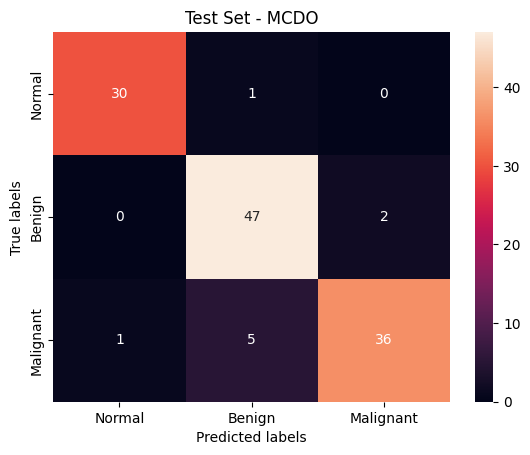

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cfm = [[30,  1,  0],
       [ 0, 47,  2],
       [ 1,  5, 36]]

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Test Set - MCDO')
plt.show()

## Entropy plot

In [ ]:
_, y_true = read_txt("/content/drive/MyDrive/CV/Project/data/test.txt")
data = np.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/MCDO.npz")
n_nn_norm_entropy = data['n_nn_norm_entropy']
n_nn_pred = data['n_nn_pred']
b_m_norm_entropy = data['b_m_norm_entropy']
b_m_pred = data['b_m_pred']
total_pred = [b_m_pred[i]+1 if n_nn_pred[i] != 0 else n_nn_pred[i] for i in range(len(n_nn_pred))]

In [ ]:
# Initiate entropy lists
correct_entropy = []
incorrect_entropy = []

# Create the true labels for Normal vs. Non-Normal classifier: Normal -> 0, Non-Normal -> 1
n_nn_y_true = [0 if x==0 else 1 for x in y_true]

# Iterate over samples
for y, p, e in zip(n_nn_y_true, n_nn_pred, n_nn_norm_entropy):
  # Append the entropy of instances to corresponding lists whether their classification is correct or incorrect
  if y == p:
    correct_entropy.append(round(e,3))
  else:
    incorrect_entropy.append(round(e,3))

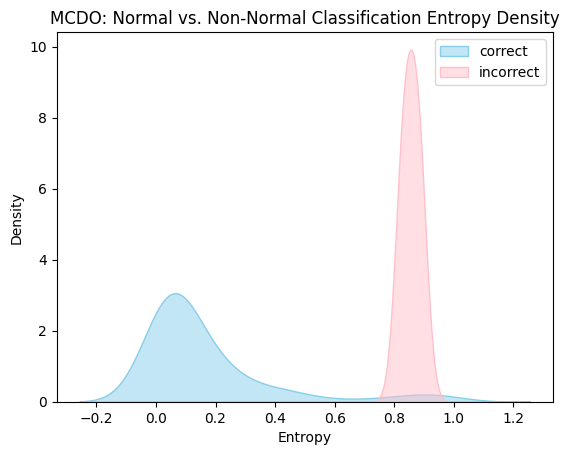

In [ ]:
sns.kdeplot(correct_entropy, color="skyblue", fill=True, alpha = 0.5, label="correct")
sns.kdeplot(incorrect_entropy, color="pink", fill=True, alpha = 0.5, label="incorrect")

plt.title("MCDO: Normal vs. Non-Normal Classification Entropy Density")
plt.xlabel("Entropy")
plt.legend()
plt.show()
plt.show()

In [ ]:
correct_entropy = []
incorrect_entropy = []
b_m_y_true = [y-1 for y,p in zip(y_true, total_pred) if p!=0]
b_m_pred_cls = [c for c,p in zip(b_m_pred, total_pred) if p!=0]
b_m_pred_entropy = [e for e,p in zip(b_m_norm_entropy, total_pred) if p!=0]
for y, p, e in zip(b_m_y_true, b_m_pred_cls, b_m_pred_entropy):
  if y == p:
    correct_entropy.append(round(e,3))
  else:
    incorrect_entropy.append(round(e,3))

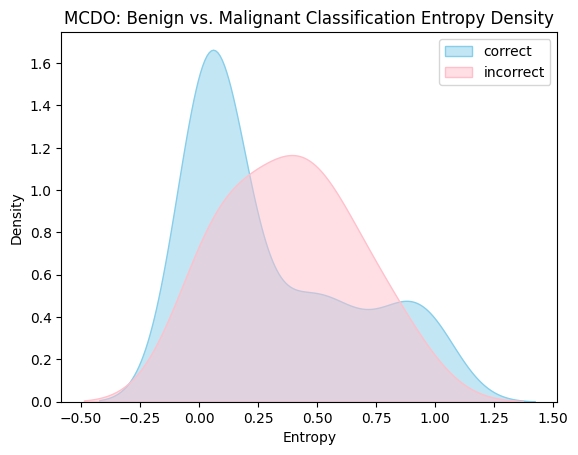

In [ ]:
 sns.kdeplot(correct_entropy, color="skyblue", fill=True, alpha = 0.5, label="correct")
sns.kdeplot(incorrect_entropy, color="pink", fill=True, alpha = 0.5, label="incorrect")

plt.title("MCDO: Benign vs. Malignant Classification Entropy Density")
plt.xlabel("Entropy")
plt.legend()
plt.show()

## Entropy Threshold

In [ ]:
# Define entropy thresholds
entropy_thresholds = np.linspace(0.1,1,10)

# Initiating the lists
y_true_per_threshold = []
total_pred_per_threshold = []
accuracies_per_threshold = []
entropies_per_threshold = []

# Iterate over thresholds
for threshold in entropy_thresholds:
  threshold_y_true = []
  threshold_total_pred = []
  threshold_entropies = []

  # Iterate over predictions
  for i in range(len(y_true)):
    # Select the samples with uncertainty value less than the current threshold
    if (total_pred[i]==0 and n_nn_norm_entropy[i] <= threshold):
      threshold_y_true.append(y_true[i])
      threshold_total_pred.append(total_pred[i])
      threshold_entropies.append(n_nn_norm_entropy[i])
    elif (total_pred[i] != 0 and b_m_norm_entropy[i] <= threshold):
      threshold_y_true.append(y_true[i])
      threshold_total_pred.append(total_pred[i])
      threshold_entropies.append(b_m_norm_entropy[i])

  entropies_per_threshold.append(threshold_entropies)
  accuracies_per_threshold.append(round(accuracy_score(threshold_y_true, threshold_total_pred)*100, 2))
  y_true_per_threshold.append(threshold_y_true)
  total_pred_per_threshold.append(threshold_total_pred)

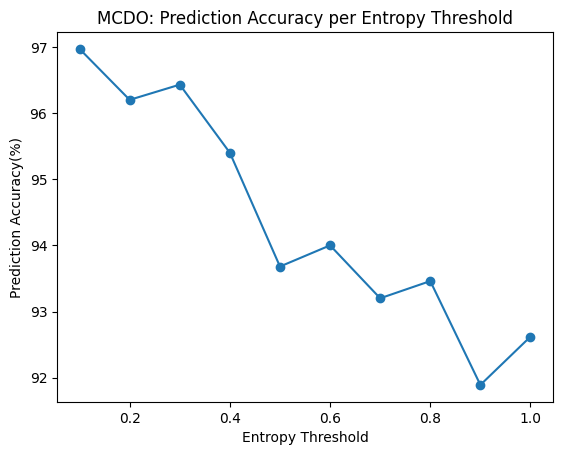

In [ ]:
plt.plot(entropy_thresholds, accuracies_per_threshold, "o-")
plt.title("MCDO: Prediction Accuracy per Entropy Threshold")
plt.xlabel("Entropy Threshold")
plt.ylabel("Prediction Accuracy(%)")
plt.show()

## Error Analysis

In [ ]:
mcdo_file_path = "/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/MCDO.npz"
total_pred, n_nn_pred, n_nn_norm_entropy, b_m_pred, b_m_norm_entropy  = evaluate_uncertainty(mcdo_file_path)

Acc: 0.9262 Spec: 0.9750 Sens: 0.8571
Normal vs Not Noraml Acc: 0.9836 Benign vs Malignant Acc: 0.9222
Confusion Matrix:
 [[30  1  0]
 [ 0 47  2]
 [ 1  5 36]]


In [ ]:
fnames, y_true = read_txt("/content/drive/MyDrive/CV/Project/data/test.txt")
data = np.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/MCDO.npz")
n_nn_norm_entropy = data['n_nn_norm_entropy']
n_nn_pred = data['n_nn_pred']
b_m_norm_entropy = data['b_m_norm_entropy']
b_m_pred = data['b_m_pred']
total_pred = [b_m_pred[i]+1 if n_nn_pred[i] != 0 else n_nn_pred[i] for i in range(len(n_nn_pred))]

In [ ]:
for y, p, f, n_nn_e, b_m_e in zip(y_true, total_pred, fnames, n_nn_norm_entropy, b_m_norm_entropy):
  if y != p:
    print(f"fname: {f}, true: {y}, pred: {p}")
    print(f"n-nn entropy: {n_nn_e}, b-m entropy: {b_m_e}\n")

fname: im00530.jpg, true: 2, pred: 1
n-nn entropy: 0.251029905781866, b-m entropy: 0.49206738685895945

fname: im00043.jpg, true: 2, pred: 0
n-nn entropy: 0.832291155885124, b-m entropy: nan

fname: im01190.jpg, true: 1, pred: 2
n-nn entropy: 0.01297141586171556, b-m entropy: 0.8304654611397552

fname: im00270.jpg, true: 2, pred: 1
n-nn entropy: 0.06870688697143224, b-m entropy: 0.058785152689473014

fname: im00944.jpg, true: 2, pred: 1
n-nn entropy: 0.046683219155040694, b-m entropy: 0.05369668803111087

fname: im00057.jpg, true: 1, pred: 2
n-nn entropy: 0.015099858764457285, b-m entropy: 0.19383732500666845

fname: im00697.jpg, true: 2, pred: 1
n-nn entropy: 0.23426466330283552, b-m entropy: 0.41833144290142626

fname: im00880.jpg, true: 2, pred: 1
n-nn entropy: 0.9247948476048423, b-m entropy: 0.3870089552913988

fname: im00482.jpg, true: 0, pred: 1
n-nn entropy: 0.879042953871817, b-m entropy: 0.6307389684339543



# TTA

In [ ]:
width = 224
height = 224
min_size = 224
max_size = 224
gold_curriculum = False
no_attn = True # No attention
combined="resnet_layer4"
retinanet_backbone="resnet50-coco"
do_hierarchical_cls=True
bm_fc_layers="3"
dropout=0.5
checkpoint_path = "/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/GBCRet, layer4 combination, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN, CrossEntropyLoss, dropout=0.5, bm_fc_layers=3/checkpoints/best_model_epoch_51.pth"
val_txt_path = "/content/drive/MyDrive/CV/Project/data/test.txt"
save_path = "/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/TTA.npz"

gbcret = GBCRet_combined(continue_training = True, combined=combined, gold_curriculum=gold_curriculum,
                         retinanet_backbone=retinanet_backbone, width=width, height=height, min_size=min_size,
                         max_size=max_size, no_attn=no_attn, dropout=dropout, do_hierarchical_cls=do_hierarchical_cls,
                         bm_fc_layers=bm_fc_layers, return_logits=True).to(device)

checkpoint = torch.load(checkpoint_path, map_location=device)
gbcret.load_state_dict(checkpoint['model_state_dict'], strict=False)
gbcret.eval()

# Without Aug.
eval_transform = get_eval_transforms(width, height)
val_dataset = InputDataset(imgs_folder_path, val_txt_path, gold_file_path, to_blur=False, img_transforms=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=5, collate_fn= collate_fn)
print("\nResults before TTA\n")
acc, cfm, y_true, y_pred, fnames, all_bboxes, all_logits = evaluate_model(gbcret, val_loader, return_bboxes=True)

print("\nResuts after TTA\n")
# With Aug.
eval_transform = get_train_transforms(width, height)
val_dataset = InputDataset(imgs_folder_path, val_txt_path, gold_file_path, to_blur=False, img_transforms=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=5, collate_fn= collate_fn)
do_mcdo=False
n_forward_passes=200
total_pred, n_nn_pred, n_nn_norm_entropy, b_m_pred, b_m_norm_entropy = estimate_uncertainty(model=gbcret, val_loader=val_loader,
                                                                                            n_forward_passes=n_forward_passes,
                                                                                            n_classes=2, n_samples=122, y_true=y_true,
                                                                                            do_mcdo=do_mcdo, save_path=save_path)

Retinanet's COCO pre-trained weights are loaded.

Results before TTA

mIoU = 0.6586982607841492, median IoU: 0.6912720203399658
TP: 116, FN: 0, FP: 6
Precision: 0.9508196721311475
Recall: 1.0
Acc: 0.9262 Spec: 0.9750 Sens: 0.8571
Normal vs Not Noraml Acc: 0.9836 Benign vs Malignant Acc: 0.9222

Resuts after TTA

Acc: 0.9180 Spec: 0.9625 Sens: 0.8333
Normal vs Not Noraml Acc: 0.9918 Benign vs Malignant Acc: 0.9000
Confusion Matrix:
 [[31  0  0]
 [ 0 46  3]
 [ 1  6 35]]


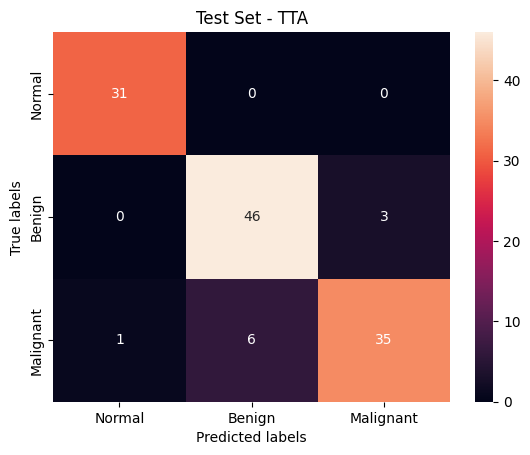

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cfm = [[31,  0,  0],
       [ 0, 46,  3],
       [ 1,  6, 35]]

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Test Set - TTA')
plt.show()

## Entropy plot

In [ ]:
_, y_true = read_txt("/content/drive/MyDrive/CV/Project/data/test.txt")
data = np.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/TTA.npz")
n_nn_norm_entropy = data['n_nn_norm_entropy']
n_nn_pred = data['n_nn_pred']
b_m_norm_entropy = data['b_m_norm_entropy']
b_m_pred = data['b_m_pred']
total_pred = [b_m_pred[i]+1 if n_nn_pred[i] != 0 else n_nn_pred[i] for i in range(len(n_nn_pred))]

In [ ]:
# Initiate entropy lists
correct_entropy = []
incorrect_entropy = []

# Create the true labels for Normal vs. Non-Normal classifier: Normal -> 0, Non-Normal -> 1
n_nn_y_true = [0 if x==0 else 1 for x in y_true]

# Iterate over samples
for y, p, e in zip(n_nn_y_true, n_nn_pred, n_nn_norm_entropy):
  # Append the entropy of instances to corresponding lists whether their classification is correct or incorrect
  if y == p:
    correct_entropy.append(round(e,3))
  else:
    incorrect_entropy.append(round(e,3))

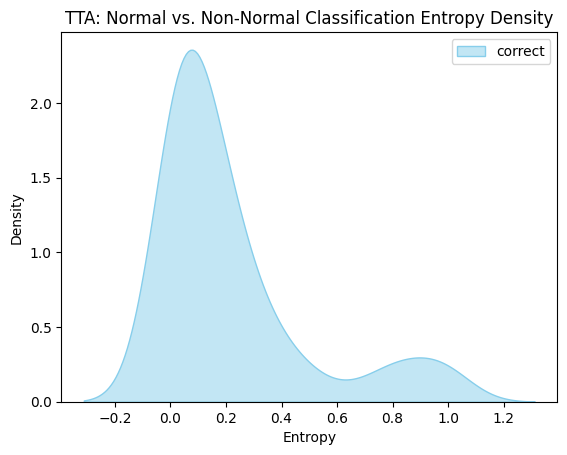

In [ ]:
sns.kdeplot(correct_entropy, color="skyblue", fill=True, alpha = 0.5, label="correct")
sns.kdeplot(incorrect_entropy, color="pink", fill=True, alpha = 0.5, label="incorrect")

plt.title("TTA: Normal vs. Non-Normal Classification Entropy Density")
plt.xlabel("Entropy")
plt.legend()
plt.show()
plt.show()

In [ ]:
correct_entropy = []
incorrect_entropy = []
b_m_y_true = [y-1 for y,p in zip(y_true, total_pred) if p!=0]
b_m_pred_cls = [c for c,p in zip(b_m_pred, total_pred) if p!=0]
b_m_pred_entropy = [e for e,p in zip(b_m_norm_entropy, total_pred) if p!=0]
for y, p, e in zip(b_m_y_true, b_m_pred_cls, b_m_pred_entropy):
  if y == p:
    correct_entropy.append(round(e,3))
  else:
    incorrect_entropy.append(round(e,3))

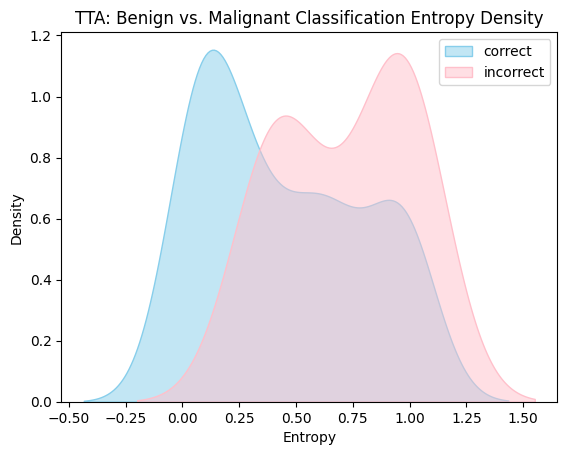

In [ ]:
sns.kdeplot(correct_entropy, color="skyblue", fill=True, alpha = 0.5, label="correct")
sns.kdeplot(incorrect_entropy, color="pink", fill=True, alpha = 0.5, label="incorrect")

plt.title("TTA: Benign vs. Malignant Classification Entropy Density")
plt.xlabel("Entropy")
plt.legend()
plt.show()

## Entropy Threshold

In [ ]:
# Define entropy thresholds
entropy_thresholds = np.linspace(0.1,1,10)

# Initiating the lists
y_true_per_threshold = []
total_pred_per_threshold = []
accuracies_per_threshold = []
entropies_per_threshold = []

# Iterate over thresholds
for threshold in entropy_thresholds:
  threshold_y_true = []
  threshold_total_pred = []
  threshold_entropies = []

  # Iterate over predictions
  for i in range(len(y_true)):
    # Select the samples with uncertainty value less than the current threshold
    if (total_pred[i]==0 and n_nn_norm_entropy[i] <= threshold):
      threshold_y_true.append(y_true[i])
      threshold_total_pred.append(total_pred[i])
      threshold_entropies.append(n_nn_norm_entropy[i])
    elif (total_pred[i] != 0 and b_m_norm_entropy[i] <= threshold):
      threshold_y_true.append(y_true[i])
      threshold_total_pred.append(total_pred[i])
      threshold_entropies.append(b_m_norm_entropy[i])

  entropies_per_threshold.append(threshold_entropies)
  accuracies_per_threshold.append(round(accuracy_score(threshold_y_true, threshold_total_pred)*100, 2))
  y_true_per_threshold.append(threshold_y_true)
  total_pred_per_threshold.append(threshold_total_pred)

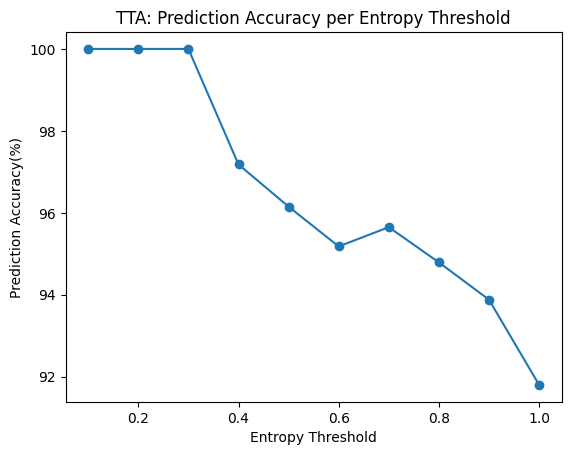

In [ ]:
plt.plot(entropy_thresholds, accuracies_per_threshold, "o-")
plt.title("TTA: Prediction Accuracy per Entropy Threshold")
plt.xlabel("Entropy Threshold")
plt.ylabel("Prediction Accuracy(%)")
plt.show()

## Error Analysis

In [ ]:
tta_file_path = "/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/TTA.npz"
total_pred, n_nn_pred, n_nn_norm_entropy, b_m_pred, b_m_norm_entropy  = evaluate_uncertainty(tta_file_path)

Acc: 0.9180 Spec: 0.9625 Sens: 0.8333
Normal vs Not Noraml Acc: 0.9918 Benign vs Malignant Acc: 0.9000
Confusion Matrix:
 [[31  0  0]
 [ 0 46  3]
 [ 1  6 35]]


In [ ]:
fnames, y_true = read_txt("/content/drive/MyDrive/CV/Project/data/test.txt")
data = np.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/TTA.npz")
n_nn_norm_entropy = data['n_nn_norm_entropy']
n_nn_pred = data['n_nn_pred']
b_m_norm_entropy = data['b_m_norm_entropy']
b_m_pred = data['b_m_pred']
total_pred = [b_m_pred[i]+1 if n_nn_pred[i] != 0 else n_nn_pred[i] for i in range(len(n_nn_pred))]

In [ ]:
for y, p, f, n_nn_e, b_m_e in zip(y_true, total_pred, fnames, n_nn_norm_entropy, b_m_norm_entropy):
  if y != p:
    print(f"fname: {f}, true: {y}, pred: {p}")
    print(f"n-nn entropy: {n_nn_e}, b-m entropy: {b_m_e}\n")

fname: im01024.jpg, true: 2, pred: 1
n-nn entropy: 0.06526252052247929, b-m entropy: 0.5521128988957181

fname: im00530.jpg, true: 2, pred: 1
n-nn entropy: 0.2009197253852836, b-m entropy: 0.7959486530290899

fname: im00043.jpg, true: 2, pred: 0
n-nn entropy: 0.8895594692720743, b-m entropy: 0.5835423374397891

fname: im00837.jpg, true: 1, pred: 2
n-nn entropy: 0.9997636983516807, b-m entropy: 0.9990563277873531

fname: im00818.jpg, true: 1, pred: 2
n-nn entropy: 0.1851997981324524, b-m entropy: 0.9919505689483069

fname: im00270.jpg, true: 2, pred: 1
n-nn entropy: 0.08056415189846872, b-m entropy: 0.35252215803143827

fname: im00944.jpg, true: 2, pred: 1
n-nn entropy: 0.0797176751453876, b-m entropy: 0.4235002504978155

fname: im01146.jpg, true: 1, pred: 2
n-nn entropy: 0.009043523310769285, b-m entropy: 0.9655637224185288

fname: im00697.jpg, true: 2, pred: 1
n-nn entropy: 0.16271434946049643, b-m entropy: 0.9931626967204115

fname: im00880.jpg, true: 2, pred: 1
n-nn entropy: 0.96392

# MCDO and TTA

In [ ]:
width = 224
height = 224
min_size = 224
max_size = 224
gold_curriculum = False
no_attn = True # No attention
combined="resnet_layer4"
retinanet_backbone="resnet50-coco"
do_hierarchical_cls=True
bm_fc_layers="3"
dropout=0.5
checkpoint_path = "/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/GBCRet, layer4 combination, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN, CrossEntropyLoss, dropout=0.5, bm_fc_layers=3/checkpoints/best_model_epoch_51.pth"
val_txt_path = "/content/drive/MyDrive/CV/Project/data/test.txt"
save_path = "/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/MCDO and TTA.npz"

gbcret = GBCRet_combined(continue_training = True, combined=combined, gold_curriculum=gold_curriculum,
                         retinanet_backbone=retinanet_backbone, width=width, height=height, min_size=min_size,
                         max_size=max_size, no_attn=no_attn, dropout=dropout, do_hierarchical_cls=do_hierarchical_cls,
                         bm_fc_layers=bm_fc_layers, return_logits=True).to(device)

checkpoint = torch.load(checkpoint_path, map_location=device)
gbcret.load_state_dict(checkpoint['model_state_dict'], strict=False)
gbcret.eval()

# Without Aug.
eval_transform = get_eval_transforms(width, height)
val_dataset = InputDataset(imgs_folder_path, val_txt_path, gold_file_path, to_blur=False, img_transforms=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=5, collate_fn= collate_fn)
print("\nResults before MCDO and TTA\n")
acc, cfm, y_true, y_pred, fnames, all_bboxes, all_logits = evaluate_model(gbcret, val_loader, return_bboxes=True)

print("\nResuts after MCDO and TTA\n")
# With Aug.
eval_transform = get_train_transforms(width, height)
val_dataset = InputDataset(imgs_folder_path, val_txt_path, gold_file_path, to_blur=False, img_transforms=eval_transform)
val_loader = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=5, collate_fn= collate_fn)
do_mcdo=True
n_forward_passes=200
total_pred, n_nn_pred, n_nn_norm_entropy, b_m_pred, b_m_norm_entropy = estimate_uncertainty(model=gbcret, val_loader=val_loader,
                                                                                            n_forward_passes=n_forward_passes,
                                                                                            n_classes=2, n_samples=122, y_true=y_true,
                                                                                            do_mcdo=do_mcdo, save_path=save_path)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth
100%|██████████| 146M/146M [00:01<00:00, 100MB/s]


Retinanet's COCO pre-trained weights are loaded.

Results before MCDO and TTA

mIoU = 0.6586982607841492, median IoU: 0.6912720203399658
TP: 116, FN: 0, FP: 6
Precision: 0.9508196721311475
Recall: 1.0
Acc: 0.9262 Spec: 0.9750 Sens: 0.8571
Normal vs Not Noraml Acc: 0.9836 Benign vs Malignant Acc: 0.9222

Resuts after MCDO and TTA

Acc: 0.9180 Spec: 0.9625 Sens: 0.8333
Normal vs Not Noraml Acc: 0.9918 Benign vs Malignant Acc: 0.9000
Confusion Matrix:
 [[31  0  0]
 [ 0 46  3]
 [ 1  6 35]]


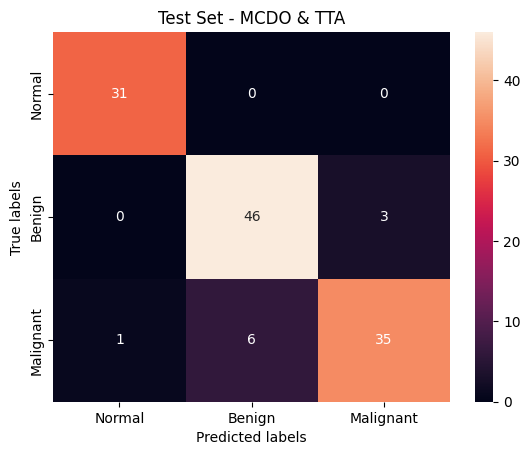

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cfm = [[31,  0,  0],
       [ 0, 46,  3],
       [ 1,  6, 35]]

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Test Set - MCDO & TTA')
plt.show()

## Entropy plot

In [ ]:
_, y_true = read_txt("/content/drive/MyDrive/CV/Project/data/test.txt")
data = np.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/MCDO and TTA.npz")
n_nn_norm_entropy = data['n_nn_norm_entropy']
n_nn_pred = data['n_nn_pred']
b_m_norm_entropy = data['b_m_norm_entropy']
b_m_pred = data['b_m_pred']
total_pred = [b_m_pred[i]+1 if n_nn_pred[i] != 0 else n_nn_pred[i] for i in range(len(n_nn_pred))]

In [ ]:
# Initiate entropy lists
correct_entropy = []
incorrect_entropy = []

# Create the true labels for Normal vs. Non-Normal classifier: Normal -> 0, Non-Normal -> 1
n_nn_y_true = [0 if x==0 else 1 for x in y_true]

# Iterate over samples
for y, p, e in zip(n_nn_y_true, n_nn_pred, n_nn_norm_entropy):
  # Append the entropy of instances to corresponding lists whether their classification is correct or incorrect
  if y == p:
    correct_entropy.append(round(e,3))
  else:
    incorrect_entropy.append(round(e,3))

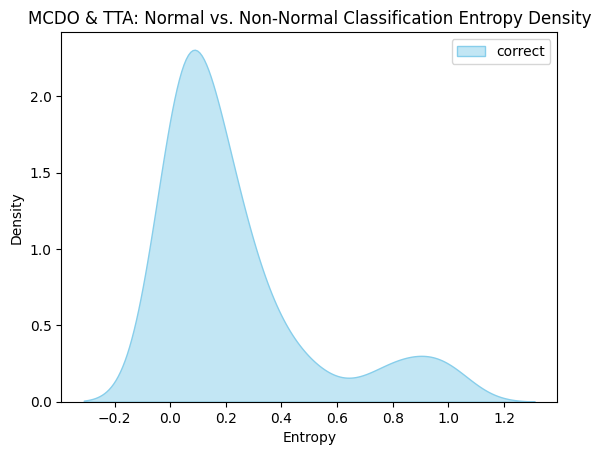

In [ ]:
sns.kdeplot(correct_entropy, color="skyblue", fill=True, alpha = 0.5, label="correct")
sns.kdeplot(incorrect_entropy, color="pink", fill=True, alpha = 0.5, label="incorrect")

plt.title("MCDO & TTA: Normal vs. Non-Normal Classification Entropy Density")
plt.xlabel("Entropy")
plt.legend()
plt.show()
plt.show()

In [ ]:
correct_entropy = []
incorrect_entropy = []
b_m_y_true = [y-1 for y,p in zip(y_true, total_pred) if p!=0]
b_m_pred_cls = [c for c,p in zip(b_m_pred, total_pred) if p!=0]
b_m_pred_entropy = [e for e,p in zip(b_m_norm_entropy, total_pred) if p!=0]
for y, p, e in zip(b_m_y_true, b_m_pred_cls, b_m_pred_entropy):
  if y == p:
    correct_entropy.append(round(e,3))
  else:
    incorrect_entropy.append(round(e,3))

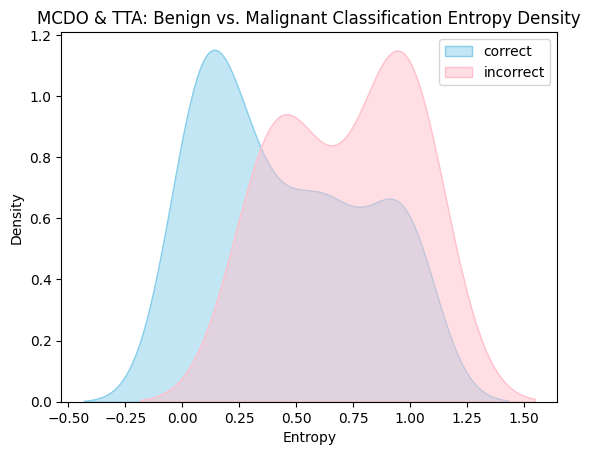

In [ ]:
sns.kdeplot(correct_entropy, color="skyblue", fill=True, alpha = 0.5, label="correct")
sns.kdeplot(incorrect_entropy, color="pink", fill=True, alpha = 0.5, label="incorrect")

plt.title("MCDO & TTA: Benign vs. Malignant Classification Entropy Density")
plt.xlabel("Entropy")
plt.legend()
plt.show()

## Entropy Threshold

In [ ]:
# Define entropy thresholds
entropy_thresholds = np.linspace(0.1,1,10)

# Initiating the lists
y_true_per_threshold = []
total_pred_per_threshold = []
accuracies_per_threshold = []
entropies_per_threshold = []

# Iterate over thresholds
for threshold in entropy_thresholds:
  threshold_y_true = []
  threshold_total_pred = []
  threshold_entropies = []

  # Iterate over predictions
  for i in range(len(y_true)):
    # Select the samples with uncertainty value less than the current threshold
    if (total_pred[i]==0 and n_nn_norm_entropy[i] <= threshold):
      threshold_y_true.append(y_true[i])
      threshold_total_pred.append(total_pred[i])
      threshold_entropies.append(n_nn_norm_entropy[i])
    elif (total_pred[i] != 0 and b_m_norm_entropy[i] <= threshold):
      threshold_y_true.append(y_true[i])
      threshold_total_pred.append(total_pred[i])
      threshold_entropies.append(b_m_norm_entropy[i])

  entropies_per_threshold.append(threshold_entropies)
  accuracies_per_threshold.append(round(accuracy_score(threshold_y_true, threshold_total_pred)*100, 2))
  y_true_per_threshold.append(threshold_y_true)
  total_pred_per_threshold.append(threshold_total_pred)

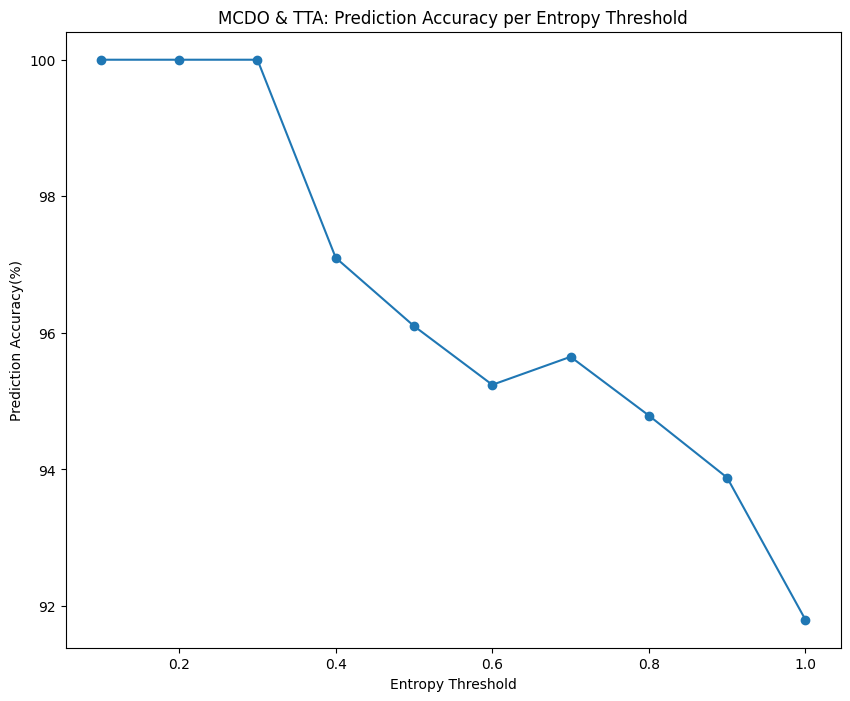

In [ ]:

plt.plot(entropy_thresholds, accuracies_per_threshold, "o-")
plt.title("MCDO & TTA: Prediction Accuracy per Entropy Threshold")
plt.xlabel("Entropy Threshold")
plt.ylabel("Prediction Accuracy(%)")
plt.show()

## Error Analysis

In [ ]:
both_file_path = "/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/MCDO and TTA.npz"
total_pred, n_nn_pred, n_nn_norm_entropy, b_m_pred, b_m_norm_entropy  = evaluate_uncertainty(both_file_path)

Acc: 0.9180 Spec: 0.9625 Sens: 0.8333
Normal vs Not Noraml Acc: 0.9918 Benign vs Malignant Acc: 0.9000
Confusion Matrix:
 [[31  0  0]
 [ 0 46  3]
 [ 1  6 35]]


In [ ]:
fnames, y_true = read_txt("/content/drive/MyDrive/CV/Project/data/test.txt")
data = np.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/MCDO and TTA.npz")
n_nn_norm_entropy = data['n_nn_norm_entropy']
n_nn_pred = data['n_nn_pred']
b_m_norm_entropy = data['b_m_norm_entropy']
b_m_pred = data['b_m_pred']
total_pred = [b_m_pred[i]+1 if n_nn_pred[i] != 0 else n_nn_pred[i] for i in range(len(n_nn_pred))]

In [ ]:
for y, p, f, n_nn_e, b_m_e in zip(y_true, total_pred, fnames, n_nn_norm_entropy, b_m_norm_entropy):
  if y != p:
    print(f"fname: {f}, true: {y}, pred: {p}")
    print(f"n-nn entropy: {n_nn_e}, b-m entropy: {b_m_e}\n")

fname: im01024.jpg, true: 2, pred: 1
n-nn entropy: 0.07650043528534861, b-m entropy: 0.5571688670433904

fname: im00530.jpg, true: 2, pred: 1
n-nn entropy: 0.22412881955335454, b-m entropy: 0.795682559368815

fname: im00043.jpg, true: 2, pred: 0
n-nn entropy: 0.898396931869954, b-m entropy: 0.6309659709372941

fname: im00837.jpg, true: 1, pred: 2
n-nn entropy: 0.9996531285660635, b-m entropy: 0.9989639789245544

fname: im00818.jpg, true: 1, pred: 2
n-nn entropy: 0.2092593684020499, b-m entropy: 0.9916387550837767

fname: im00270.jpg, true: 2, pred: 1
n-nn entropy: 0.0965765370851835, b-m entropy: 0.3626761076072278

fname: im00944.jpg, true: 2, pred: 1
n-nn entropy: 0.09407417062353118, b-m entropy: 0.43419439390185605

fname: im01146.jpg, true: 1, pred: 2
n-nn entropy: 0.01581470727496848, b-m entropy: 0.9669836451173471

fname: im00697.jpg, true: 2, pred: 1
n-nn entropy: 0.18359950502730257, b-m entropy: 0.9921991087624477

fname: im00880.jpg, true: 2, pred: 1
n-nn entropy: 0.9687341

# MCDO + TTA

In [ ]:
mcdo_data = np.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/MCDO.npz")
tta_data = np.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/TTA.npz")
mcdo_n_nn_total_predictions = mcdo_data['n_nn_total_predictions']
tta_n_nn_total_predictions = tta_data['n_nn_total_predictions']
mcdo_b_m_total_predictions = mcdo_data['b_m_total_predictions']
tta_b_m_total_predictions = tta_data['b_m_total_predictions']

In [ ]:
print(f"mcdo_n_nn_total_predictions shape: {mcdo_n_nn_total_predictions.shape}")
print(f"tta_n_nn_total_predictions shape: {tta_n_nn_total_predictions.shape}")
print(f"mcdo_b_m_total_predictions shape: {mcdo_b_m_total_predictions.shape}")
print(f"tta_b_m_total_predictions shape: {tta_b_m_total_predictions.shape}")

mcdo_n_nn_total_predictions shape: (200, 122, 2)
tta_n_nn_total_predictions shape: (200, 122, 2)
mcdo_b_m_total_predictions shape: (200, 122, 2)
tta_b_m_total_predictions shape: (200, 122, 2)


In [ ]:
both_n_nn_total_predictions = np.concatenate((mcdo_n_nn_total_predictions, tta_n_nn_total_predictions))
print(f"both_n_nn_total_predictions shape: {both_n_nn_total_predictions.shape}")

both_b_m_total_predictions = np.concatenate((mcdo_b_m_total_predictions, tta_b_m_total_predictions))
print(f"both_n_nn_total_predictions shape: {both_b_m_total_predictions.shape}")

both_n_nn_total_predictions shape: (400, 122, 2)
both_n_nn_total_predictions shape: (400, 122, 2)


In [ ]:
n_nn_mean = np.mean(both_n_nn_total_predictions, axis=0)
n_nn_pred = np.argmax(n_nn_mean, axis=1)
n_nn_entropy = -1 * np.sum(np.log(n_nn_mean + 1e-5) * n_nn_mean, axis=1)
n_nn_norm_entropy = (n_nn_entropy - n_nn_entropy.min())/(n_nn_entropy.max() - n_nn_entropy.min())

b_m_mean = np.nanmean(both_b_m_total_predictions, axis=0)
b_m_pred = np.argmax(b_m_mean, axis=1)
b_m_entropy = -1 * np.sum(np.log(b_m_mean + 1e-5) * b_m_mean, axis=1)
b_m_norm_entropy = (b_m_entropy - np.nanmin(b_m_entropy))/(np.nanmax(b_m_entropy) - np.nanmin(b_m_entropy))

total_pred = [b_m_pred[i]+1 if n_nn_pred[i] != 0 else n_nn_pred[i] for i in range(len(n_nn_pred))]

acc = accuracy_score(y_true, total_pred)
cfm = confusion_matrix(y_true, total_pred)
spec = (cfm[0][0] + cfm[0][1] + cfm[1][0] + cfm[1][1])/(np.sum(cfm[0]) + np.sum(cfm[1]))
sens = cfm[2][2]/np.sum(cfm[2])
n_nn_acc = (cfm[0,0] + np.sum(cfm[1:,1:]))/np.sum(cfm)
b_m_acc = (cfm[1,1] + cfm[2,2])/np.sum(cfm[1:,1:])
print('Acc: {:.4f} Spec: {:.4f} Sens: {:.4f}\nNormal vs Not Noraml Acc: {:.4f} Benign vs Malignant Acc: {:.4f}\nConfusion Matrix:\n {}'.format(acc, spec, sens, n_nn_acc, b_m_acc, cfm))


Acc: 0.9180 Spec: 0.9625 Sens: 0.8571
Normal vs Not Noraml Acc: 0.9836 Benign vs Malignant Acc: 0.9111
Confusion Matrix:
 [[30  1  0]
 [ 0 46  3]
 [ 1  5 36]]


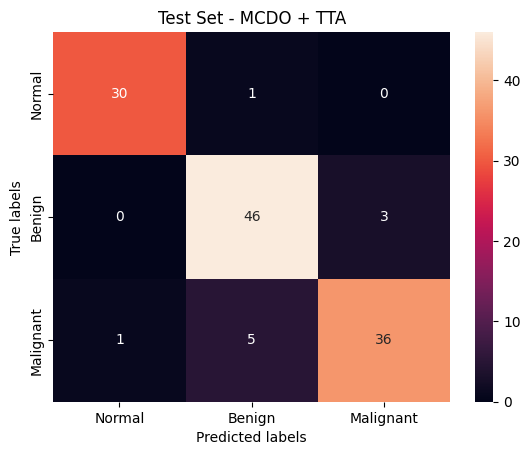

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cfm = [[30,  1,  0],
       [ 0, 46,  3],
       [ 1,  5, 36]]

# Define the labels
labels = ['Normal', 'Benign', 'Malignant']

# Plot the confusion matrix with custom labels
ax = plt.subplot()
sns.heatmap(cfm, annot=True, fmt='g', ax=ax, xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Test Set - MCDO + TTA')
plt.show()

In [ ]:
save_path = "/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/MCDO + TTA.npz"
np.savez(save_path, n_nn_total_predictions=both_n_nn_total_predictions, b_m_total_predictions=both_b_m_total_predictions,
        n_nn_mean=n_nn_mean, n_nn_pred=n_nn_pred, n_nn_norm_entropy=n_nn_norm_entropy,
        b_m_mean=b_m_mean, b_m_pred=b_m_pred, b_m_norm_entropy=b_m_norm_entropy)

## Entropy plot

In [ ]:
_, y_true = read_txt("/content/drive/MyDrive/CV/Project/data/test.txt")
data = np.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/MCDO + TTA.npz")
n_nn_norm_entropy = data['n_nn_norm_entropy']
n_nn_pred = data['n_nn_pred']
b_m_norm_entropy = data['b_m_norm_entropy']
b_m_pred = data['b_m_pred']
total_pred = [b_m_pred[i]+1 if n_nn_pred[i] != 0 else n_nn_pred[i] for i in range(len(n_nn_pred))]

In [ ]:
# Initiate entropy lists
correct_entropy = []
incorrect_entropy = []

# Create the true labels for Normal vs. Non-Normal classifier: Normal -> 0, Non-Normal -> 1
n_nn_y_true = [0 if x==0 else 1 for x in y_true]

# Iterate over samples
for y, p, e in zip(n_nn_y_true, n_nn_pred, n_nn_norm_entropy):
  # Append the entropy of instances to corresponding lists whether their classification is correct or incorrect
  if y == p:
    correct_entropy.append(round(e,3))
  else:
    incorrect_entropy.append(round(e,3))

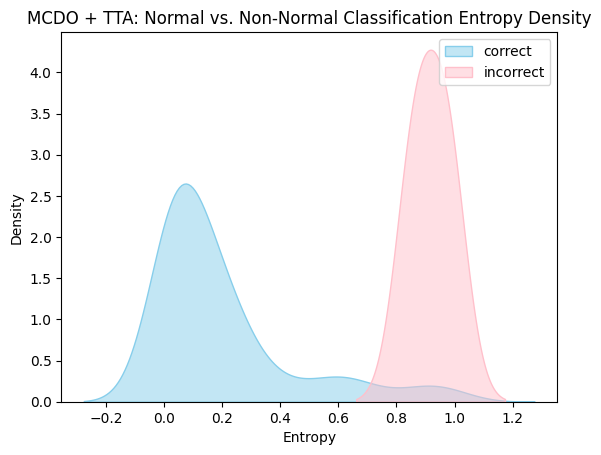

In [ ]:
sns.kdeplot(correct_entropy, color="skyblue", fill=True, alpha = 0.5, label="correct")
sns.kdeplot(incorrect_entropy, color="pink", fill=True, alpha = 0.5, label="incorrect")

plt.title("MCDO + TTA: Normal vs. Non-Normal Classification Entropy Density")
plt.xlabel("Entropy")
plt.legend()
plt.show()
plt.show()

In [ ]:
correct_entropy = []
incorrect_entropy = []
b_m_y_true = [y-1 for y,p in zip(y_true, total_pred) if p!=0]
b_m_pred_cls = [c for c,p in zip(b_m_pred, total_pred) if p!=0]
b_m_pred_entropy = [e for e,p in zip(b_m_norm_entropy, total_pred) if p!=0]
for y, p, e in zip(b_m_y_true, b_m_pred_cls, b_m_pred_entropy):
  if y == p:
    correct_entropy.append(round(e,3))
  else:
    incorrect_entropy.append(round(e,3))

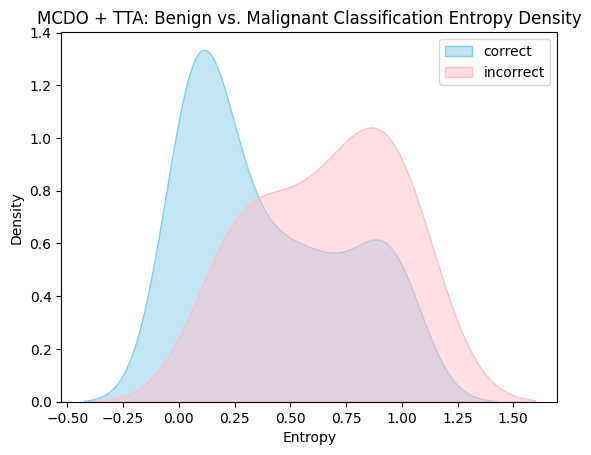

In [ ]:
sns.kdeplot(correct_entropy, color="skyblue", fill=True, alpha = 0.5, label="correct")
sns.kdeplot(incorrect_entropy, color="pink", fill=True, alpha = 0.5, label="incorrect")

plt.title("MCDO + TTA: Benign vs. Malignant Classification Entropy Density")
plt.xlabel("Entropy")
plt.legend()
plt.show()

## Entropy Threshold

In [ ]:
# Define entropy thresholds
entropy_thresholds = np.linspace(0.1,1,10)

# Initiating the lists
y_true_per_threshold = []
total_pred_per_threshold = []
accuracies_per_threshold = []
entropies_per_threshold = []

# Iterate over thresholds
for threshold in entropy_thresholds:
  threshold_y_true = []
  threshold_total_pred = []
  threshold_entropies = []

  # Iterate over predictions
  for i in range(len(y_true)):
    # Select the samples with uncertainty value less than the current threshold
    if (total_pred[i]==0 and n_nn_norm_entropy[i] <= threshold):
      threshold_y_true.append(y_true[i])
      threshold_total_pred.append(total_pred[i])
      threshold_entropies.append(n_nn_norm_entropy[i])
    elif (total_pred[i] != 0 and b_m_norm_entropy[i] <= threshold):
      threshold_y_true.append(y_true[i])
      threshold_total_pred.append(total_pred[i])
      threshold_entropies.append(b_m_norm_entropy[i])

  entropies_per_threshold.append(threshold_entropies)
  accuracies_per_threshold.append(round(accuracy_score(threshold_y_true, threshold_total_pred)*100, 2))
  y_true_per_threshold.append(threshold_y_true)
  total_pred_per_threshold.append(threshold_total_pred)

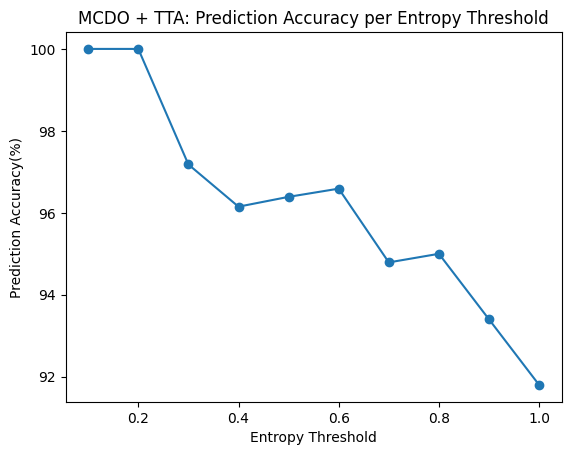

In [ ]:
plt.plot(entropy_thresholds, accuracies_per_threshold, "o-")
plt.title("MCDO + TTA: Prediction Accuracy per Entropy Threshold")
plt.xlabel("Entropy Threshold")
plt.ylabel("Prediction Accuracy(%)")
plt.show()

## Error Analysis

In [ ]:
fnames, y_true = read_txt("/content/drive/MyDrive/CV/Project/data/test.txt")
data = np.load("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/MCDO + TTA.npz")
n_nn_norm_entropy = data['n_nn_norm_entropy']
n_nn_pred = data['n_nn_pred']
b_m_norm_entropy = data['b_m_norm_entropy']
b_m_pred = data['b_m_pred']
total_pred = [b_m_pred[i]+1 if n_nn_pred[i] != 0 else n_nn_pred[i] for i in range(len(n_nn_pred))]

In [ ]:
for y, p, f, n_nn_e, b_m_e in zip(y_true, total_pred, fnames, n_nn_norm_entropy, b_m_norm_entropy):
  if y != p:
    print(f"fname: {f}, true: {y}, pred: {p}")
    print(f"n-nn entropy: {n_nn_e}, b-m entropy: {b_m_e}\n")

fname: im00530.jpg, true: 2, pred: 1
n-nn entropy: 0.2265702372513764, b-m entropy: 0.6653589678074413

fname: im00043.jpg, true: 2, pred: 0
n-nn entropy: 0.8626979431251449, b-m entropy: 0.5838527501966736

fname: im01190.jpg, true: 1, pred: 2
n-nn entropy: 0.04521416323106339, b-m entropy: 0.9896437702281082

fname: im00270.jpg, true: 2, pred: 1
n-nn entropy: 0.07470661470234072, b-m entropy: 0.22645997665068496

fname: im00944.jpg, true: 2, pred: 1
n-nn entropy: 0.06374786609848762, b-m entropy: 0.2695977611993167

fname: im01146.jpg, true: 1, pred: 2
n-nn entropy: 0.007591934602963277, b-m entropy: 0.9987768893648056

fname: im00057.jpg, true: 1, pred: 2
n-nn entropy: 0.05852780014505867, b-m entropy: 0.9634544335930024

fname: im00697.jpg, true: 2, pred: 1
n-nn entropy: 0.19975082638279332, b-m entropy: 0.8377925427307603

fname: im00880.jpg, true: 2, pred: 1
n-nn entropy: 0.9463459288803321, b-m entropy: 0.3859016702932765

fname: im00482.jpg, true: 0, pred: 1
n-nn entropy: 0.972

# discard data

In [ ]:
def sort_uncertainty(file_path):
  data = np.load(file_path)
  n_nn_pred = data['n_nn_pred']
  b_m_pred = data['b_m_pred']
  total_pred = [b_m_pred[i]+1 if n_nn_pred[i] != 0 else n_nn_pred[i] for i in range(len(n_nn_pred))]
  n_nn_norm_entropy = data['n_nn_norm_entropy']
  b_m_norm_entropy = data['b_m_norm_entropy']
  total_entropy = [n_nn_norm_entropy[i] if total_pred[i]==0 else b_m_norm_entropy[i] for i in range(len(total_pred))]
  sorted_zip = sorted(zip(total_entropy, total_pred, y_true))
  sorted_entropy, sorted_pred, sorted_true = zip(*sorted_zip)
  return sorted_entropy, sorted_pred, sorted_true

In [ ]:
mcdo_sorted_entropy ,mcdo_sorted_pred, mcdo_sorted_true = sort_uncertainty("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/MCDO.npz")
tta_sorted_entropy ,tta_sorted_pred, tta_sorted_true = sort_uncertainty("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/TTA.npz")
both_sorted_entropy ,both_sorted_pred, both_sorted_true = sort_uncertainty("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/MCDO and TTA.npz")
cat_sorted_entropy ,cat_sorted_pred, cat_sorted_true = sort_uncertainty("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/MCDO + TTA.npz")

In [ ]:
def fraction_accuracies(sorted_pred, sorted_true):
  referral_fraction = np.linspace(0,1,11)
  accuracies = []
  for fraction in referral_fraction:
    num_elements = int((1-fraction) * len(sorted_true))
    selected_pred = sorted_pred[:num_elements]
    selected_true = sorted_true[:num_elements]
    accuracies.append(round(accuracy_score(selected_true, selected_pred)*100, 2))
  return accuracies

In [ ]:
mcdo_accuracies = fraction_accuracies(mcdo_sorted_pred, mcdo_sorted_true)
tta_accuracies = fraction_accuracies(tta_sorted_pred, tta_sorted_true)
both_accuracies = fraction_accuracies(both_sorted_pred, both_sorted_true)
cat_accuracies = fraction_accuracies(cat_sorted_pred, cat_sorted_true)

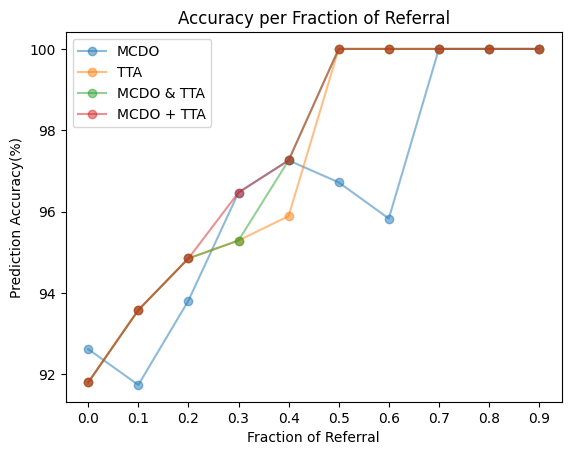

In [ ]:
data_proportion = np.linspace(0,1,11)
plt.plot(data_proportion, mcdo_accuracies, '-o', label="MCDO", alpha=0.5)
plt.plot(data_proportion, tta_accuracies, '-o', label="TTA", alpha=0.5)
plt.plot(data_proportion, both_accuracies, '-o', label="MCDO & TTA", alpha=0.5)
plt.plot(data_proportion, cat_accuracies, '-o', label="MCDO + TTA", alpha=0.5)

plt.xticks(np.linspace(0,0.9,10))
plt.legend()
plt.title("Accuracy per Fraction of Referral")
plt.xlabel("Fraction of Referral")
plt.ylabel("Prediction Accuracy(%)")

plt.show()

# Entropy Threshold

In [ ]:
def uncertainty_threshold_accuracies(file_path):
  _, y_true = read_txt("/content/drive/MyDrive/CV/Project/data/test.txt")
  data = np.load(file_path)
  n_nn_norm_entropy = data['n_nn_norm_entropy']
  n_nn_pred = data['n_nn_pred']
  b_m_norm_entropy = data['b_m_norm_entropy']
  b_m_pred = data['b_m_pred']
  total_pred = [b_m_pred[i]+1 if n_nn_pred[i] != 0 else n_nn_pred[i] for i in range(len(n_nn_pred))]

  # Define entropy thresholds
  entropy_thresholds = np.linspace(0.1,1,10)

  # Initiating the lists
  y_true_per_threshold = []
  total_pred_per_threshold = []
  accuracies_per_threshold = []
  entropies_per_threshold = []

  # Iterate over thresholds
  for threshold in entropy_thresholds:
    threshold_y_true = []
    threshold_total_pred = []
    threshold_entropies = []

    # Iterate over predictions
    for i in range(len(y_true)):
      # Select the samples with uncertainty value less than the current threshold
      if (total_pred[i]==0 and n_nn_norm_entropy[i] <= threshold):
        threshold_y_true.append(y_true[i])
        threshold_total_pred.append(total_pred[i])
        threshold_entropies.append(n_nn_norm_entropy[i])
      elif (total_pred[i] != 0 and b_m_norm_entropy[i] <= threshold):
        threshold_y_true.append(y_true[i])
        threshold_total_pred.append(total_pred[i])
        threshold_entropies.append(b_m_norm_entropy[i])

    entropies_per_threshold.append(threshold_entropies)
    accuracies_per_threshold.append(round(accuracy_score(threshold_y_true, threshold_total_pred)*100, 2))
    y_true_per_threshold.append(threshold_y_true)
    total_pred_per_threshold.append(threshold_total_pred)

  return accuracies_per_threshold

In [ ]:
mcdo_accuracies_per_threshold = uncertainty_threshold_accuracies("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/MCDO.npz")
tta_accuracies_per_threshold = uncertainty_threshold_accuracies("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/TTA.npz")
both_accuracies_per_threshold = uncertainty_threshold_accuracies("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/MCDO and TTA.npz")
cat_accuracies_per_threshold = uncertainty_threshold_accuracies("/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/Uncertainty/MCDO + TTA.npz")

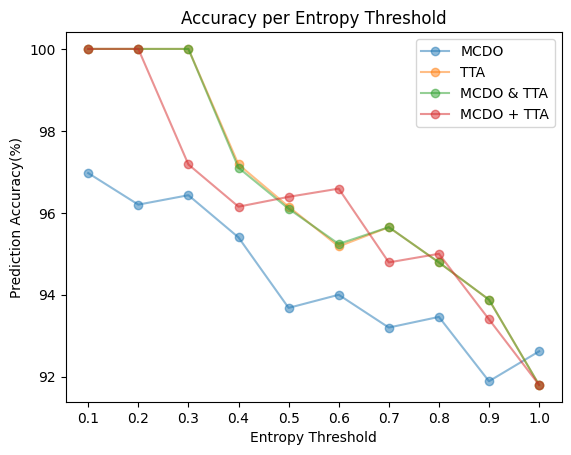

In [ ]:
plt.plot(entropy_thresholds, mcdo_accuracies_per_threshold, '-o', label="MCDO", alpha=0.5)
plt.plot(entropy_thresholds, tta_accuracies_per_threshold, '-o', label="TTA", alpha=0.5)
plt.plot(entropy_thresholds, both_accuracies_per_threshold, '-o', label="MCDO & TTA", alpha=0.5)
plt.plot(entropy_thresholds, cat_accuracies_per_threshold, '-o', label="MCDO + TTA", alpha=0.5)

plt.xticks(np.linspace(0.1,1,10))
plt.legend()
plt.title("Accuracy per Entropy Threshold")
plt.xlabel("Entropy Threshold")
plt.ylabel("Prediction Accuracy(%)")

plt.show()

# Errors of Final Model, One Forward Pass

In [ ]:
checkpoint_path = "/content/drive/MyDrive/CV/Project/ResNet, GBCNet, GBCRet, 3/GBCRet, layer4 combination, Hierarchical cls, gbcnet VA, 50 epochs pretrained RN, CrossEntropyLoss, dropout=0.5, bm_fc_layers=3/checkpoints/best_model_epoch_51.pth"
val_txt_path = "/content/drive/MyDrive/CV/Project/data/test.txt"
acc, cfm, y_true, y_pred, fnames, all_bboxes, all_logits = eval_cal(checkpoint_path, val_txt_path)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth
100%|██████████| 146M/146M [00:04<00:00, 37.5MB/s]


Retinanet's COCO pre-trained weights are loaded.
mIoU = 0.6586982607841492, median IoU: 0.6912720203399658
TP: 116, FN: 0, FP: 6
Precision: 0.9508196721311475
Recall: 1.0
Acc: 0.9262 Spec: 0.9750 Sens: 0.8571
Normal vs Not Noraml Acc: 0.9836 Benign vs Malignant Acc: 0.9222


In [ ]:
for y,p,n in zip(y_true, y_pred, fnames):
  if y != p:
    print(f"fname: {n}, y_true: {y}, y_pred: {p}")

fname: im00530.jpg, y_true: 2, y_pred: 1
fname: im00043.jpg, y_true: 2, y_pred: 0
fname: im01190.jpg, y_true: 1, y_pred: 2
fname: im00270.jpg, y_true: 2, y_pred: 1
fname: im00944.jpg, y_true: 2, y_pred: 1
fname: im00057.jpg, y_true: 1, y_pred: 2
fname: im00697.jpg, y_true: 2, y_pred: 1
fname: im00880.jpg, y_true: 2, y_pred: 1
fname: im00482.jpg, y_true: 0, y_pred: 1


# End